# 计算化学的低标度 Laplace-Transform 方法格点导出思路

> 创建时间：2022-10-26

在这份文档中，我们会首先介绍 Laplace-Transform 的定义与意义。随后给出关于 Laplace-Transform 的格点优化思路。最后我们呈现了多种情况下的预优化格点，并比较了不同的积分区间下，格点的数量对 Laplace-Transform 作为近似的误差的影响程度。

In [1]:
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
%matplotlib inline

set_matplotlib_formats('svg')

In [2]:
import numpy as np
import pandas as pd
import pickle
from scipy import integrate, optimize, interpolate
from scipy.special import expi, exp1, roots_laguerre
from numpy import exp

## Laplace-Transform 方法简介

### 对 $1/x$ 函数的变换

计算化学中，特别是类似于 MP2 或 MPn 方法、或者 RPA 方法，会对表达式 $1/x$ 进行下述变换：

$$
\frac{1}{x} = \int_0^{+\infty} \mathrm{e}^{- t x} \, \mathrm{d} t \simeq \mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x) \mathrel{:=} \sum_\alpha^\tau w_\alpha \mathrm{e}^{- t_\alpha x}
$$

对于第二个约等号，它就是将解析的积分转换为数值的积分；其数值格点为 $\boldsymbol{t}$ 或记为 $t_\alpha$，格点权重为 $\boldsymbol{w}$ 或记为 $w_\alpha$。

对于 Laplace-Transform 近似函数 $\mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x)$，其程序化实现可以通过下述函数给出：

In [3]:
def get_LT(t, w):
    t = np.asarray(t).reshape(-1, 1)
    w = np.asarray(w).reshape(-1, 1)
    def inner(x):
        res = (w * np.exp(- t * x)).sum(axis=0)
        return res if res.size > 1 else res[0]
    return inner

在 $[0,+\infty)$ 上的格点积分通常会选用 Gauss-Laguerre。因此我们不妨以这个格点，进行简单的计算。如果现在的 $x = 2$，那么我们预期的 $\mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x) \simeq 1/x = 0.5$。下述程序的 `t_GL20` 与 `w_GL20` 分别是 20 阶 Gauss-Laguerre 格点的坐标与权重。

In [4]:
t_GL20 = roots_laguerre(20)[0]
w_GL20 = np.exp(t_GL20) * roots_laguerre(20)[1]

In [5]:
get_LT(t_GL20, w_GL20)(2)

0.4999999999999991

### Laplace-Transform 在张量运算的意义

事实上 Laplace-Transform 是将一个非常简单的倒数运算，转换为一个非常复杂的格点积分。在大多数情况下，这样的计算方式是非常划不来的。

但对于一些张量运算问题，这种化简为繁的变换反而会给出更优的计算复杂度。在化学中较早利用这一点的文献可以参考 Häser JCP 1991 [^Haser1991]。以下述计算问题为例：

$$
E = \sum_{ijk}^n \frac{A_{ik} A_{jk}}{\varepsilon_i + \varepsilon_j}
$$

[^Haser1991]: Häser, M.; Almlöf, J. Laplace Transform Techniques in Møller–Plesset Perturbation Theory. *J. Chem. Phys.* **1992**, *96* (1), 489–494. doi: [10.1063/1.462485](https://doi.org/10.1063/1.462485).

出于方便，我们令角标 $i, j, k$ 所对应的维度均为 $n = 1000$。该问题有两种计算上先后的方法：

$$
\begin{align*}
B_{jk} = \sum_i^n \frac{A_{ik}}{\varepsilon_i + \varepsilon_j}, \; E &= \sum_{jk}^n B_{jk} A_{jk}; \text{or} \\
C_{ij} = \sum_k^n A_{ik} A_{jk}, \; E &= \sum_{ij}^n \frac{C_{ij}}{\varepsilon_i + \varepsilon_j}
\end{align*}
$$

不论哪种计算方法，总是有单步的运算涉及到 3 个角标，因此我们认为计算复杂度为 $O(n^3) \sim 10^{9}$。

但若引入 Laplace-Transform，那么计算问题就化为

$$
\begin{align*}
E &= \sum_{ijk}^n \frac{A_{ik} A_{jk}}{\varepsilon_i + \varepsilon_j} \\
&\sim \sum_{ijk}^n \sum_\alpha^\tau w_\alpha \mathrm{e}^{- t_\alpha (\varepsilon_i + \varepsilon_j)} A_{ik} A_{jk} \\
&= \sum_{k}^n \sum_\alpha^\tau \left( w_\alpha \cdot \sum_i^n A_{ik} \mathrm{e}^{- t_\alpha \varepsilon_i} \cdot \sum_j^n A_{jk} \mathrm{e}^{- t_\alpha \varepsilon_j} \right)
\end{align*}
$$

其中 $\alpha$ 是 Laplace-Transform 所需要的格点角标，不妨认为其格点总数 $\tau \sim 20$ (事实上这个数量在实际问题中可以更低)。现在令

$$
D_{k\alpha} = \sum_i^n A_{ik} \mathrm{e}^{- t_\alpha \varepsilon_i}
$$

该步的计算过程牵涉到角标 $i k \alpha$，计算复杂度是 $O(n^2 \tau) \sim 2 \times 10^7$。随后一步是

$$
E = \sum_{k}^n \sum_\alpha^\tau w_\alpha D_{k \alpha}^2
$$

这一步只牵涉到角标 $k \alpha$，其计算消耗不关键。因此 Laplace-Transform 下整个算术计算量大概是 $2 \times 10^7$，比起未变换的方法要快上 $n / \tau \sim 50$ 倍。至此，化简为繁的 Laplace-Transform 在一部分张量运算中的意义就凸显出来了。

## Laplace-Transform 作为近似的准确性

### 20 阶 Gauss-Laguerre 格点准确性的绘图展示

我们先前已经验证了 $x = 2$ 时，在 20 阶 Gauss-Laguerre 格点下的 Laplace-Transform 的合理性了。

我们进而会再问

1. Laplace-Transform 作为近似，有多准确，在何种精度要求下可以使用；
2. 格点数 $\tau$ 与精度之间的关系怎样，多大程度上可以节省格点数量。

这节先解决第一个问题。我们首先以两种格点呈现 Laplace-Transform 准确性：

- 20 阶 Gauss-Laguerre 格点 (记为 GL-20)，格点坐标变量为 `t_GL20`、权重坐标变量为 `w_GL20`；这组格点我们已经生成过了；
- 10 点优化后的格点 (记为 L2log-10)，格点坐标变量为 `t_L2log10`、权重坐标变量为 `w_L2log10`；这组格点定义在下面的代码块中。

In [6]:
t_L2log10 = 10**np.array([
    -2.53336424, -1.68532097, -1.0947392 , -0.5937269 , -0.1473786 ,
     0.2593688 ,  0.63558393,  0.98782998,  1.32281566,  1.65472166])
w_L2log10 = 10**np.array([
    -2.09510186, -1.50144309, -1.00290442, -0.55908055, -0.1570772 ,
     0.21293416,  0.55798319,  0.88444692,  1.20302408,  1.55159606])

第一张图展示了函数 $1/x$ 与 $\mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x)$ 的大体趋势。从下图中，我们能看到的情况是：

- 对于格点 GL-20，并不是所有的 Laplace-Transform 函数 $\mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x)$ 的结果都能接近真值 $1/x$，而只有 $(0.1, 20)$ 区间内的结果接近；
- 对于格点 L2log-10，则在 $(0.1, 500)$ 区间内的结果都接近真值 $1/x$。

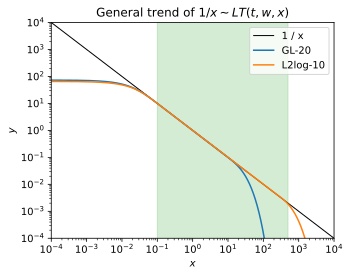

In [7]:
fig, ax = plt.subplots(figsize=(5, 4))
x = np.logspace(-4, 4, 10000)
ax.plot(x, 1 / x, color="black", linewidth=1, label="1 / x")
ax.plot(x, get_LT(t_GL20, w_GL20)(x), label=r"GL-20")
ax.plot(x, get_LT(t_L2log10, w_L2log10)(x), label=r"L2log-10")
ax.fill_between([0.1, 500], [1e10, 1e10], color="C2", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-4, 1e4)
ax.set_ylim(1e-4, 1e4)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("General trend of $1 / x \sim LT(t,w,x)$")
ax.legend()
fig.tight_layout()

若我们绘制绝对误差图，则可以更加明显地看到这个现象。

- GL-20 近似的函数在 $(0.2, 9)$ 的区间内，可以非常接近 $1/x$；但一旦超过这个区间，则近似的准确性急剧下降。
- 而对于 L2log-10 格点，在 $(0.1, 500)$ 的区间内，近似函数的误差在 $10^{-4}$ 以内波动；而超过这一区间，近似准确性也同样急剧下降。

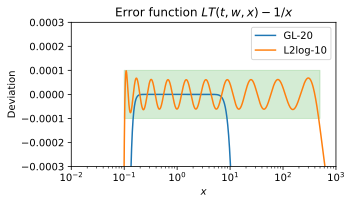

In [8]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x, get_LT(t_GL20, w_GL20)(x) - 1 / x, label="GL-20")
ax.plot(x, get_LT(t_L2log10, w_L2log10)(x) - 1 / x, label="L2log-10")
ax.fill_between([0.1, 500], [-1e-4, -1e-4], [1e-4, 1e-4], color="C2", alpha=0.2)
ax.set_xscale("log")
ax.set_xlim(1e-2, 1e3)
ax.set_ylim(-3e-4, 3e-4)
ax.set_xlabel("$x$")
ax.set_ylabel("Deviation")
ax.set_title("Error function $LT(t,w,x) - 1/x$")
ax.legend()
fig.tight_layout()

在化学中，我们对这类近似函数的要求有两点：

- 近似的绝对误差应当在 $10^{-4}$ 级别；这对应的能量误差是 $10^{-4}$ Hartree，即 0.06 kcal/mol。之所以要有这个精度要求，是因为化学精度为 1 kcal/mol。为了避免数值计算误差影响化学的认识，我们希望将误差控制在非常小的范围内。
- 至少应当保证区间 $x \in (0.1, 500)$ 内的数值有较好的近似。对于 MP2 方法而言，$x$ 就是轨道能级的差值 $\varepsilon_a + \varepsilon_b - \varepsilon_i - \varepsilon_j$；对于一般的分子而言，该数值常见的区间即是 $(0.1, 500)$。

因此，如果只是使用 20 阶的 Gauss-Laguerre 格点 GL-20，是无法满足计算化学对求取 $1/x$ 运算的需求的。相比而言，误差稍大但可接受的 L2log-10 格点不仅数量更少，并且更为适合用于化学的实际问题。

### 误差量标

在进一步考虑优化格点前，我们先规定近似函数的误差值如何确定。

其中一种误差量标是 $L_2^\mathrm{log}$ 量标。以格点 $\boldsymbol{t}$ 与相应权重 $\boldsymbol{w}$ 为变量，令下述积分损失函数 $I_2^\mathrm{log}$ 为

$$
\begin{align*}
I_2^\mathrm{log} (\boldsymbol{t}, \boldsymbol{w}) &= \int_{x_\min}^{x_\max} \left( \mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x) - \frac{1}{x} \right)^2 \mathrm{d} \log x \\
&= \int_{x_\min}^{x_\max} \frac{1}{x} \left( \sum_\alpha^\tau w_\alpha \mathrm{e}^{- t_\alpha x} - \frac{1}{x} \right)^2 \mathrm{d} x \\
&= \frac{1}{2} \left( \frac{1}{x_\min^2} - \frac{1}{x_\max^2} \right) + \sum_{\alpha \beta}^\tau w_\alpha w_\beta \left( E_1 \big( (t_\alpha + t_\beta) x_\min \big) - E_1 \big( (t_\alpha + t_\beta) x_\max \big) \right) \\
&\quad + 2 \sum_\alpha^\tau w_\alpha \left( t_\alpha \big( E_1 (t_\alpha x_\min) - E_1 (t_\alpha x_\max) \big) - \frac{\mathrm{e}^{- t_\alpha x_\min}}{x_\min} + \frac{\mathrm{e}^{- t_\alpha x_\max}}{x_\max} \right)
\end{align*}
$$

并令误差函数 $L_2^\mathrm{log}$ 为

$$
L_2^\mathrm{log} (\boldsymbol{t}, \boldsymbol{w}) = \sqrt{\frac{I_2^\mathrm{log} (\boldsymbol{t}, \boldsymbol{w})}{\log x_\max - \log x_\min}}
$$

损失函数 $I_2^\mathrm{log}$ 可以用于求取极小值；误差函数 $L_2^\mathrm{log}$ 可以用于确定与比较误差数值。

上面所出现的函数 $E_1$ 是指数积分函数 (参考 NIST 数学函数 [^DLMF])：

$$
E_1 (z) = \int_z^{+\infty} \frac{\mathrm{e}^{-t}}{t} \mathrm{d} t
$$

[^DLMF]: https://dlmf.nist.gov/6.2#E1

下述程序 `loss_L2log` 与 `err_L2log` 分别是求取 $I_2^\mathrm{log}$ 与 $L_2^\mathrm{log}$ 的函数。

In [9]:
def loss_L2log(t, w, x_min, x_max):
    t2 = t[:, None] + t
    w2 = w[:, None] * w
    l = 0.5 * (1 / x_min**2 - 1 / x_max**2)
    l += (w2 * (exp1(x_min * t2) - exp1(x_max * t2))).sum()
    l += 2 * w @ (t * (exp1(x_min * t) - exp1(x_max * t)) - exp(- x_min * t) / x_min + exp(- x_max * t) / x_max)
    return l

In [10]:
def err_L2log(t, w, x_min, x_max):
    return np.sqrt(loss_L2log(t, w, x_min, x_max) / (np.log(x_max) - np.log(x_min)))

我们可以对先前考察过的格点 GL20 (Gauss-Laguerre 20 格点) 与 L2log-10 (优化的 10 格点) 给出 $(0.1, 500)$ 区间内的 $L_2$ 误差值：

In [11]:
err_L2log(t_GL20, w_GL20, 0.1, 500)

0.005887670938251206

In [12]:
err_L2log(t_L2log10, w_L2log10, 0.1, 500)

4.676641107400367e-05

### 权重的确定方式

若已知格点 $\boldsymbol{t}$ 使得 $I_2^\mathrm{log} (\boldsymbol{t}, \boldsymbol{w})$ 可以取到最小值，那么其对应的格点权重 $\boldsymbol{w}$ 可以通过下述方式给出：

$$
\boldsymbol{w}: \frac{\partial I_2^\mathrm{log} (\boldsymbol{t}, \boldsymbol{w})}{\partial \boldsymbol{w}} = \boldsymbol{0}
$$

该求取过程可以化为下述向量计算问题：

$$
\mathbf{A} \boldsymbol{w} = \boldsymbol{b}
$$

其中，

$$
\begin{align*}
A_{\alpha \beta} &= \int_{x_\min}^{x_\max} \frac{\mathrm{e}^{- (t_\alpha + t_\beta) x}}{x} \mathrm{d} x \\
&= E_1 \big( (t_\alpha + t_\beta) x_\min \big) - E_1 \big( (t_\alpha + t_\beta) x_\max \big) \\
b_\alpha &= \int_{x_\min}^{x_\max} \frac{\mathrm{e}^{- t_\alpha x}}{x^2} \mathrm{d} x \\
&= \frac{\mathrm{e}^{- t_\alpha x_\min}}{x_\min} - \frac{\mathrm{e}^{- t_\alpha x_\max}}{x_\max} - t_\alpha \big( E_1 (t_\alpha x_\min) - E_1 (t_\alpha x_\max) \big)
\end{align*}
$$

下述函数可以求得特定格点 $\boldsymbol{t}$ 下对应的权重 $\boldsymbol{w}$：

In [13]:
def get_w_L2log(t, x_min, x_max):
    t2 = t[:, None] + t
    a = exp1(t2 * x_min) - exp1(t2 * x_max)
    b = exp(- t * x_min) / x_min - exp(- t * x_max) / x_max - t * (exp1(t * x_min) - exp1(t * x_max))
    return np.linalg.solve(a, b)

### 格点优化

到此为止，我们可以实现格点优化了。但其中仍然有一些实现细节需要关注：

- 我们的目标误差是非常小的，$L_2^\mathrm{log}$ 可能在 $10^{-5}$ 量级，而 $I_2^\mathrm{log}$ 可能在 $10^{-8}$ 量级。将 $I_2^\mathrm{log}$ 交给库函数进行优化时，很可能因为函数值变化太小而不会优化到底。因此，我们可以对 $I_2^\mathrm{log}$ 乘上较大的数 ($10^{7}$) 以避免优化不进行。
- 由于格点可能非常小，格点更适合以其对数 $\log \boldsymbol{t}$ 而非直接对 $\boldsymbol{t}$ 进行优化。
- 对于 L-BFGS-B 或 BFGS 等直接利用梯度信息的方法，由于数值误差的存在，需要对数值导数的差分值作额外设定，并且有可能无法优化到最佳情况。在这些梯度方法后，最好接上 Simplex 优化方法譬如 Nelder-Mead 等，并且可能需要使用多次，经常可以再将误差缩小一些。
- 一些特殊情况下，优化过程中，两个格点距离太近；这导致权重数值会存在巨大的一正一负。这容易产生严重的数值误差，从而给出错误的负的损失函数。遇到这种情况需要手动重新优化。

下述函数过程就是对 $(x_\min, x_\max) = (0.1, 500)$ 区间，对于 10 格点情形，以 $[10^{-3}, 10^{2.5}]$ 为 $\boldsymbol{t}$ 的取值区间的等比数列为初猜，作以 $I_2^\mathrm{log}$ 的优化。优化后的结果中，`res.x` 是 $\log \boldsymbol{t}$，而 `res.fun` 是 $10^7 I_2^\mathrm{log}$ 的数值。

In [14]:
def loss_work_L2log(x_min, x_max):
    def inner(t_log10):
        t = 10**t_log10
        w = get_w_L2log(t, x_min, x_max)
        l = loss_L2log(t, w, x_min, x_max)
        return l * 1e7
    return inner

In [15]:
t_init = np.linspace(-3, 2.5, 10)
res = optimize.minimize(loss_work_L2log(0.1, 500), t_init,
                        method="L-BFGS-B", options={"maxiter": 100, "eps": 1e-5})
print("I2log Optimize after L-BFGS-B           :", res.fun)
res = optimize.minimize(loss_work_L2log(0.1, 500), res.x,
                        method="Nelder-Mead", options={"maxiter": 5000})
print("I2log Optimize after Nelder-Mead, iter 1:", res.fun)
res = optimize.minimize(loss_work_L2log(0.1, 500), res.x,
                        method="Nelder-Mead", options={"maxiter": 5000})
print("I2log Optimize after Nelder-Mead, iter 2:", res.fun)

I2log Optimize after L-BFGS-B           : 0.7694336545682745
I2log Optimize after Nelder-Mead, iter 1: 0.19717305121957907
I2log Optimize after Nelder-Mead, iter 2: 0.1862790099949052


In [16]:
res.x

array([-2.53336424, -1.68532097, -1.0947392 , -0.5937269 , -0.1473786 ,
        0.2593688 ,  0.63558393,  0.98782998,  1.32281566,  1.65472166])

In [17]:
np.log10(get_w_L2log(10**res.x, 0.1, 500))

array([-2.09510186, -1.50144309, -1.00290442, -0.55908055, -0.1570772 ,
        0.21293416,  0.55798319,  0.88444692,  1.20302408,  1.55159606])

事实上我们之前使用的 L2log-10 格点 `t_L2log10` 就是通过这种方式导出的。可以验证，`10**res.x` 的结果与 `t_L2log10` 是非常接近的。

## 更普遍的格点

对于一般情况而言，上述的 $(x_\min, x_\max) = (0.1, 500)$ 区间内 10 点格点，已经足够用于一般的化学问题了。但如果遇到更普遍的问题，比如分子体系或基组过大 (以至于分母数值需要上千)，或者 HOMO/LUMO gap 数值太小 (小于 0.1 Hartree)，那么上述的格点就不适用了。

同时，如果实际的问题要求并不高，只需要在区间 $(x_\min, x_\max) = (0.5, 50)$ 能计算准确即可 (譬如水分子的 B3LYP/6-31G)，那么 10 个积分格点甚至都太多了。

由于当前问题作为最小值优化问题，其存在较大的潜在数值误差问题；因此实际上不适合依据化学问题的需求，自动化地给出当前问题最佳的格点。这更适合预先手动优化一些格点；而后依据特定问题和特定需求，代入合适的预优化的格点。这一节我们就对一些可以预见的情况作提前优化。

在优化中所使用到的一些方便的函数被折叠在下方。

In [18]:
def print_outputs(res, x_min, x_max, nspace=0, ret=False):
    x_list = np.logspace(np.log10(x_min), np.log10(x_max), 100000)
    t1 = np.sort(res.x)
    t2 = get_w_L2log(10**t1, x_min, x_max)
    t3 = np.log10(np.abs(t2))
    t4 = np.sign(t2)
    t5 = err_L2log(10**t1, t2, x_min, x_max)
    t6 = np.abs(get_LT(10**t1, t2)(x_list) - 1 / x_list).max()
    print(" "*nspace + "\"grid_log\": " + "[" + ", ".join(["{:18.10}".format(i).strip() for i in t1]).strip() + "],")
    print(" "*nspace + "\"weight_log\": " + "[" + ", ".join(["{:18.10}".format(i).strip() for i in t3]).strip() + "],")
    print(" "*nspace + "\"weight_sgn\": " + "[" + ", ".join(["{:}".format(int(i)) for i in t4]).strip() + "],")
    print(" "*nspace + "\"L2_err\": {:10.4e},".format(t5))
    print(" "*nspace + "\"max_err\": {:10.4e},".format(t6))
    if ret:
        return {
            "grid_log": t1,
            "weight_log": t3,
            "weight_sgn": np.int(t4),
            "L2_err": t5,
            "max_err": t6,
        }

In [19]:
def scale_points(x, tau, x_min=None, x_max=None):
    x = np.sort(x)
    x_min = np.min(x) if x_min is None else x_min
    x_max = np.max(x) if x_max is None else x_max
    spl = interpolate.interp1d(np.linspace(0, 1, res.x.size), np.sort(res.x))
    new_x = spl(np.linspace(0, 1, tau))
    new_x = x_min + (new_x - new_x.min()) * (x_max - x_min) / (new_x.max() - new_x.min())
    return new_x

优化的结果放入变量 `optimized_LT` 中。由于数据量太大，我们将该结果也进行了折叠。

使用该变量的方式是，

In [20]:
optimized_LT = {
    (0.01, 100): {
        5: {
            "grid_log": [-0.4437405929, 0.5680664814, 1.278880164, 1.859062781, 2.371080954],
            "weight_log": [0.04714588325, 0.8394718905, 1.441894483, 1.951473521, 2.431730904],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.2277e-02,
            "max_err": 1.8173e-01,
        },
        6: {
            "grid_log": [-0.8234891489, 0.1883133656, 0.899042822, 1.478150712, 1.980197149, 2.440110907],
            "weight_log": [-0.3326039064, 0.4597124774, 1.061884433, 1.568330784, 2.01879262, 2.461305197],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.8206e-02,
            "max_err": 7.8775e-02,
        },
        7: {
            "grid_log": [-1.174354992, -0.1631596654, 0.5472191491, 1.125972089, 1.626428494, 2.075227207, 2.496803354],
            "weight_log": [-0.6836876674, 0.1079912861, 0.7098673755, 1.215686496, 1.661762788, 2.070902548, 2.485406634],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.1051e-03,
            "max_err": 3.6127e-02,
        },
        8: {
            "grid_log": [-1.453308278, -0.4621218916, 0.237216967, 0.8096459118, 1.30572437, 1.749736539, 2.157236757, 2.547492197],
            "weight_log": [-0.9699507922, -0.1991141396, 0.3943135352, 0.8952459368, 1.337318234, 1.738701947, 2.115287004, 2.506806312],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.5244e-03,
            "max_err": 1.6601e-02,
        },
        9: {
            "grid_log": [-1.624636324, -0.6821797381, -0.01273343996, 0.5419687112, 1.026256825, 1.461453044, 1.860318313, 2.232960685, 2.595707863],
            "weight_log": [-1.158249975, -0.4412557822, 0.1285364341, 0.6158267211, 1.048525524, 1.442023583, 1.806885567, 2.155705499, 2.527002767],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.4876e-03,
            "max_err": 7.3290e-03,
        },
        10: {
            "grid_log": [-1.740400638, -0.8481044747, -0.216078561, 0.3145355877, 0.7822079445, 1.205126595, 1.594205485, 1.957020797, 2.300800219, 2.640064945],
            "weight_log": [-1.289811817, -0.6345529595, -0.09669315373, 0.3715064383, 0.7908808129, 1.174311917, 1.53025651, 1.865676001, 2.191444221, 2.545485992],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.2059e-04,
            "max_err": 3.2005e-03,
        },
        11: {
            "grid_log": [-1.82858538, -0.9777023776, -0.3840974739, 0.1193166471, 0.5675854925, 0.9759903722, 1.353745163, 1.70710788, 2.040947923, 2.360856865, 2.680212034],
            "weight_log": [-1.389584568, -0.7917142077, -0.2900725754, 0.1559216171, 0.5596742206, 0.9313260151, 1.277872208, 1.604400595, 1.915984804, 2.222651951, 2.562096757],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.5728e-04,
            "max_err": 1.4121e-03,
        },
        12: {
            "grid_log": [-1.908899609, -1.092661659, -0.5390285127, -0.06710187223, 0.3589718988, 0.752204805, 1.119476284, 1.465308101, 1.7930494, 2.105728436, 2.407870343, 2.71214226],
            "weight_log": [-1.478572506, -0.9344364428, -0.4754208084, -0.05560828848, 0.3320590494, 0.6934745771, 1.033043736, 1.35423825, 1.659968777, 1.95418483, 2.246660044, 2.575125909],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.0888e-04,
            "max_err": 7.0355e-04,
        },
    },
    (0.01, 200): {
        5: {
            "grid_log": [-0.4437436926, 0.568063034, 1.278877359, 1.859060322, 2.371079684],
            "weight_log": [0.04714223259, 0.8394689042, 1.441891797, 1.951471739, 2.431730734],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.0817e-02,
            "max_err": 1.8173e-01,
        },
        6: {
            "grid_log": [-0.8234847723, 0.1883217738, 0.8990457539, 1.478151133, 1.980198196, 2.440111772],
            "weight_log": [-0.3325963085, 0.4597192776, 1.061883774, 1.568331169, 2.018794098, 2.461305437],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.7665e-02,
            "max_err": 7.8775e-02,
        },
        7: {
            "grid_log": [-1.175842415, -0.1640443831, 0.5466618933, 1.12559987, 1.626176465, 2.075059998, 2.496700601],
            "weight_log": [-0.6849559205, 0.1073478029, 0.709472289, 1.215432764, 1.661602112, 2.070809071, 2.485362505],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.0511e-03,
            "max_err": 3.6181e-02,
        },
        8: {
            "grid_log": [-1.503672049, -0.4928481615, 0.2173329618, 0.7959560992, 1.2960896, 1.743004847, 2.152690615, 2.544638883],
            "weight_log": [-1.013140626, -0.221844636, 0.3798838248, 0.8855480362, 1.330812734, 1.734522949, 2.112839607, 2.505604976],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.7512e-03,
            "max_err": 1.7381e-02,
        },
        9: {
            "grid_log": [-1.761192156, -0.7713048249, -0.07268012984, 0.4993472568, 0.9951145708, 1.438602923, 1.843840387, 2.221544565, 2.588364019],
            "weight_log": [-1.278304037, -0.5088377335, 0.08406420564, 0.5846754914, 1.026403862, 1.426628799, 1.796750558, 2.149658067, 2.523955193],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.7069e-03,
            "max_err": 8.3381e-03,
        },
        10: {
            "grid_log": [-1.922512198, -0.9787833181, -0.3085033904, 0.2467157485, 0.7313726085, 1.166817533, 1.565508312, 1.935914608, 2.285839768, 2.630176146],
            "weight_log": [-1.455699893, -0.7372395324, -0.166775232, 0.3209331004, 0.7539438772, 1.147534509, 1.511278191, 1.852874783, 2.183569632, 2.54136248],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.5795e-04,
            "max_err": 3.8758e-03,
        },
        11: {
            "grid_log": [-2.051259494, -1.163289631, -0.5332517107, -3.149319669e-05, 0.4734304508, 0.9025121735, 1.296759573, 1.663343815, 2.008047203, 2.337080831, 2.664193686],
            "weight_log": [-1.602008549, -0.9520988802, -0.4136804344, 0.06103450782, 0.4882901143, 0.8778382224, 1.238037723, 1.575467788, 1.896113816, 2.21024904, 2.555476159],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.3833e-04,
            "max_err": 1.9705e-03,
        },
        12: {
            "grid_log": [-2.125389659, -1.27227999, -0.6756846045, -0.1692338007, 0.2820187468, 0.6933728662, 1.073924742, 1.429736809, 1.765265245, 2.084360829, 2.392041247, 2.701200571],
            "weight_log": [-1.685857624, -1.084474014, -0.5791975874, -0.1298790392, 0.2771255173, 0.6519134861, 1.001208062, 1.329788235, 1.641578777, 1.94113577, 2.238278986, 2.570515491],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.4687e-04,
            "max_err": 9.0160e-04,
        },
        13: {
            "grid_log": [-2.242663993, -1.438882431, -0.8999751995, -0.4334919477, -0.0004036354294, 0.4070801402, 0.7893808431, 1.148142368, 1.486662411, 1.808321239, 2.116272199, 2.414952595, 2.716716004],
            "weight_log": [-1.815253757, -1.291732456, -0.8464302187, -0.4208923358, -0.0148645491, 0.3657031429, 0.7198687453, 1.051994314, 1.366815622, 1.667825022, 1.95893656, 2.249491558, 2.57670034],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.1263e-05,
            "max_err": 6.3702e-04,
        },
    },
    (0.01, 500): {
        5: {
            "grid_log": [-0.4437410932, 0.5680651316, 1.278879221, 1.859063022, 2.371082342],
            "weight_log": [0.04714490555, 0.8394705056, 1.44189409, 1.951474926, 2.431732818],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 3.9063e-02,
            "max_err": 1.8172e-01,
        },
        6: {
            "grid_log": [-0.8234842002, 0.1883157611, 0.8990437752, 1.478151282, 1.980197022, 2.440109457],
            "weight_log": [-0.3325998434, 0.4597137903, 1.061884804, 1.568331181, 2.018791339, 2.461302784],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.6929e-02,
            "max_err": 7.8781e-02,
        },
        7: {
            "grid_log": [-1.17584977, -0.164059402, 0.5466511229, 1.125592263, 1.626174457, 2.075061097, 2.496702208],
            "weight_log": [-0.6849691391, 0.1073344643, 0.7094633909, 1.215429148, 1.661604674, 2.070811618, 2.485363988],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.7654e-03,
            "max_err": 3.6180e-02,
        },
        8: {
            "grid_log": [-1.506047477, -0.4942547958, 0.2164611603, 0.795383143, 1.295696942, 1.742731987, 2.152506649, 2.544525327],
            "weight_log": [-1.015164339, -0.222861029, 0.3792787846, 0.8851596384, 1.330552251, 1.734353185, 2.112741798, 2.505560311],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.7187e-03,
            "max_err": 1.7410e-02,
        },
        9: {
            "grid_log": [-1.817476907, -0.8058453438, -0.09524468353, 0.4835591911, 0.9837357649, 1.430371138, 1.837972682, 2.217505865, 2.585774141],
            "weight_log": [-1.326652115, -0.5345198152, 0.06749447885, 0.5732375828, 1.018422806, 1.42116593, 1.793178746, 2.147523374, 2.522877843],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.8242e-03,
            "max_err": 8.7229e-03,
        },
        10: {
            "grid_log": [-2.0863587, -1.085546628, -0.3807535414, 0.1948488146, 0.6930013659, 1.138149174, 1.544215434, 1.920424403, 2.274986573, 2.623072651],
            "weight_log": [-1.599511793, -0.8185424306, -0.220873466, 0.282512726, 0.726139063, 1.12752985, 1.497288947, 1.843598094, 2.177934081, 2.538430183],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.8510e-04,
            "max_err": 4.4350e-03,
        },
        11: {
            "grid_log": [-2.266497961, -1.304081684, -0.6218666627, -0.05950108983, 0.4300172894, 0.8691638014, 1.270835572, 1.643401567, 1.993046424, 2.326184335, 2.656770414],
            "weight_log": [-1.793318525, -1.053693385, -0.4737152104, 0.01951879354, 0.456528502, 0.8533209381, 1.219602572, 1.562114181, 1.886886517, 2.204345248, 2.552214884],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.1946e-04,
            "max_err": 2.3107e-03,
        },
        12: {
            "grid_log": [-2.38765623, -1.471387237, -0.8201599032, -0.2762300626, 0.2014536886, 0.6324052316, 1.027798931, 1.395047971, 1.739543861, 2.065708767, 2.378940364, 2.692503758],
            "weight_log": [-1.929747752, -1.244030054, -0.6889614172, -0.2094449835, 0.2187871893, 0.6092158723, 0.9701264583, 1.307607425, 1.626294927, 1.931093597, 2.232116086, 2.567182798],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.9643e-04,
            "max_err": 1.0852e-03,
        },
        13: {
            "grid_log": [-2.493629016, -1.626599794, -1.01656112, -0.4999377613, -0.04023084668, 0.3791040217, 0.7675818486, 1.131158734, 1.473976829, 1.799303583, 2.110150823, 2.410953729, 2.714206602],
            "weight_log": [-2.050282773, -1.429165117, -0.9108592497, -0.4524124551, -0.0370195445, 0.3462890272, 0.7040970985, 1.04065328, 1.359388845, 1.663337598, 1.956388168, 2.248077264, 2.575922097],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.5716e-05,
            "max_err": 6.7283e-04,
        },
        14: {
            "grid_log": [-2.593915195, -1.771886747, -1.209073638, -0.7256768011, -0.2876251695, 0.1173220605, 0.4966043669, 0.8548867037, 1.19544611, 1.520948167, 1.833387556, 2.134588467, 2.428077144, 2.725608717],
            "weight_log": [-2.162251051, -1.608344868, -1.136455694, -0.7026116795, -0.3021781663, 0.07187609176, 0.4248643716, 0.7598421424, 1.079633493, 1.386534111, 1.681980902, 1.968763688, 2.255788861, 2.5801373],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.6856e-05,
            "max_err": 5.2501e-04,
        },
        15: {
            "grid_log": [-57.41062746, -2.20154656, -1.557798543, -1.056811892, -0.6105002993, -0.1991704204, 0.186512168, 0.5518238571, 0.8992731209, 1.230733154, 1.548291627, 1.854047165, 2.149950529, 2.439257018, 2.733345379],
            "weight_log": [-2.813845748, -1.92980446, -1.459850028, -1.023951616, -0.6179731931, -0.2378348335, 0.1226730214, 0.4655762857, 0.7918528727, 1.103688236, 1.403726151, 1.69408999, 1.97722293, 2.261353386, 2.583363235],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.5007e-05,
            "max_err": 4.3403e-04,
        },
    },
    (0.01, 1000): {
        5: {
            "grid_log": [-0.4437396892, 0.5680645618, 1.278878121, 1.859061236, 2.371080885],
            "weight_log": [0.04714524592, 0.8394696318, 1.441892415, 1.951472969, 2.431731971],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 3.7870e-02,
            "max_err": 1.8172e-01,
        },
        6: {
            "grid_log": [-0.8234842641, 0.1883132444, 0.8990409922, 1.478148914, 1.980196005, 2.440109485],
            "weight_log": [-0.3326011439, 0.4597108422, 1.061881987, 1.568329642, 2.018791598, 2.461303416],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.6416e-02,
            "max_err": 7.8780e-02,
        },
        7: {
            "grid_log": [-1.175840122, -0.1640536851, 0.5466578517, 1.125600268, 1.626181922, 2.075067279, 2.496706979],
            "weight_log": [-0.6849614495, 0.1073397059, 0.7094714211, 1.215437415, 1.66161109, 2.070816456, 2.485367154],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.5367e-03,
            "max_err": 3.6176e-02,
        },
        8: {
            "grid_log": [-1.506133988, -0.4943398024, 0.2163728483, 0.7953010621, 1.295630532, 1.742685958, 2.152477824, 2.544506287],
            "weight_log": [-1.015248532, -0.2229482305, 0.3791907897, 0.885087016, 1.330503384, 1.734327832, 2.112727518, 2.505549272],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.6231e-03,
            "max_err": 1.7419e-02,
        },
        9: {
            "grid_log": [-1.818004323, -0.8062268408, -0.0955255891, 0.4833854541, 0.9836647017, 1.430369235, 1.83799737, 2.217528455, 2.585786482],
            "weight_log": [-1.327125602, -0.5348412937, 0.06728284099, 0.573153581, 1.018434447, 1.421212244, 1.793212964, 2.147535374, 2.522878789],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.8047e-03,
            "max_err": 8.7225e-03,
        },
        10: {
            "grid_log": [-2.11411018, -1.102579608, -0.3920131877, 0.1868291275, 0.6870889964, 1.133732929, 1.540915064, 1.91798808, 2.273249609, 2.621924138],
            "weight_log": [-1.62332354, -0.8312903022, -0.22927415, 0.2765673593, 0.7218440637, 1.124422632, 1.495071085, 1.84207963, 2.176993487, 2.537945828],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.1700e-04,
            "max_err": 4.5310e-03,
        },
        11: {
            "grid_log": [-2.3787988, -1.377030567, -0.6716733519, -0.0956119946, 0.4030294367, 0.8487925117, 1.255561588, 1.632154477, 1.984973397, 2.320593769, 2.653137334],
            "weight_log": [-1.891594333, -1.109643082, -0.5114598719, -0.007577755079, 0.4366704066, 0.838872206, 1.209379024, 1.555153761, 1.882376335, 2.201644744, 2.550819688],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.6202e-04,
            "max_err": 2.4774e-03,
        },
        12: {
            "grid_log": [-2.662664512, -1.734877957, -1.071643075, -0.508785743, -6.243520104e-06, 0.4677287425, 0.8970347951, 1.292622778, 1.660469725, 2.006140882, 2.335845379, 2.663411567],
            "weight_log": [-2.201273033, -1.500744606, -0.9303103244, -0.4209770042, 0.05035928168, 0.481219963, 0.8735755648, 1.235470637, 1.57396885, 1.89525599, 2.209742239, 2.555184559],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.8777e-04,
            "max_err": 2.0033e-03,
        },
        13: {
            "grid_log": [-2.681632633, -1.76269291, -1.109440974, -0.5643145149, -0.08556385758, 0.3467549978, 0.7441148212, 1.113873085, 1.461175179, 1.789828643, 2.103152948, 2.405856669, 2.710692579],
            "weight_log": [-2.222917287, -1.533817247, -0.977146932, -0.4966317603, -0.06712928337, 0.3252991922, 0.6890260028, 1.029735932, 1.351563138, 1.657753052, 1.952431739, 2.245452568, 2.574463743],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.1259e-04,
            "max_err": 7.2679e-04,
        },
        14: {
            "grid_log": [-2.783861803, -1.914060489, -1.302291021, -0.7857582077, -0.3278374039, 0.08929947987, 0.4766547801, 0.8407484501, 1.185603985, 1.514192956, 1.828810705, 2.131583555, 2.42615177, 2.724412982],
            "weight_log": [-2.339607136, -1.715050475, -1.195897581, -0.7391851012, -0.3268907624, 0.05448672996, 0.4128086104, 0.7518599199, 1.074536568, 1.383266344, 1.680009566, 1.96767575, 2.255159011, 2.579808388],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.2211e-05,
            "max_err": 5.3562e-04,
        },
        15: {
            "grid_log": [-2.918077918, -2.1024273, -1.544622474, -1.062922135, -0.6244848626, -0.2167454029, 0.168043853, 0.534292865, 0.8841557988, 1.219047943, 1.540324132, 1.849257463, 2.147317089, 2.43783095, 2.73253957],
            "weight_log": [-2.48817292, -1.943517447, -1.474607777, -1.040450343, -0.637481159, -0.2576363227, 0.1043217134, 0.450148818, 0.78059022, 1.096953873, 1.400713789, 1.693183001, 1.977012077, 2.26120394, 2.583191982],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.5961e-05,
            "max_err": 4.4222e-04,
        },
    },
    (0.02, 100): {
        5: {
            "grid_log": [-0.7447622556, 0.2670407767, 0.9778526388, 1.558034148, 2.070052178],
            "weight_log": [-0.2538774878, 0.5384449109, 1.140865865, 1.650444495, 2.130702073],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 2.1881e-02,
            "max_err": 9.0862e-02,
        },
        6: {
            "grid_log": [-1.123951222, -0.112381561, 0.5982181397, 1.177251859, 1.67925086, 2.139129285],
            "weight_log": [-0.6331504364, 0.158923674, 0.7609941805, 1.267385461, 1.717809514, 2.1602943],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 9.2325e-03,
            "max_err": 3.9365e-02,
        },
        7: {
            "grid_log": [-1.433878609, -0.4393865929, 0.2618282887, 0.8353638138, 1.332414201, 1.778793156, 2.198569735],
            "weight_log": [-0.9493240892, -0.1749993683, 0.4198837205, 0.9217221796, 1.36513371, 1.772374877, 2.185558286],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.8248e-03,
            "max_err": 1.7343e-02,
        },
        8: {
            "grid_log": [-1.621583878, -0.6778636594, -0.007597639933, 0.5476086066, 1.032259366, 1.468044622, 1.869314062, 2.254714628],
            "weight_log": [-1.154771605, -0.4363296903, 0.1341244142, 0.6218075722, 1.05488055, 1.449672782, 1.821303883, 2.20924425],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5258e-03,
            "max_err": 7.2587e-03,
        },
        9: {
            "grid_log": [-1.744258926, -0.8537820265, -0.2232363459, 0.30641411, 0.7734293433, 1.195883007, 1.584921616, 1.949781678, 2.306264535],
            "weight_log": [-1.29421201, -0.6413215112, -0.1047525705, 0.3627005317, 0.7815565956, 1.164693855, 1.521537375, 1.864148695, 2.230843858],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.9986e-04,
            "max_err": 2.9677e-03,
        },
        10: {
            "grid_log": [-1.836978202, -0.9901072126, -0.4007504635, 0.09951105615, 0.5457013454, 0.9527826577, 1.329684414, 1.682811369, 2.018731408, 2.351552346],
            "weight_log": [-1.39902184, -0.8071041497, -0.3097538988, 0.13374312, 0.5361163685, 0.9069422839, 1.253052912, 1.580601246, 1.900164867, 2.249568039],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.3405e-04,
            "max_err": 1.2516e-03,
        },
        11: {
            "grid_log": [-1.910600436, -1.095211107, -0.5424644045, -0.07148581259, 0.3526082964, 0.7425247392, 1.105617372, 1.447013477, 1.770887221, 2.082410123, 2.39460847],
            "weight_log": [-1.480481019, -0.9376778012, -0.4795287625, -0.06127939026, 0.3228265926, 0.6793632704, 1.013772417, 1.330301016, 1.633590191, 1.933481659, 2.267581993],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.0791e-05,
            "max_err": 5.0309e-04,
        },
        12: {
            "grid_log": [-1.983076219, -1.19330787, -0.6764234183, -0.2378000724, 0.1614408054, 0.5333649889, 0.8835438743, 1.215320219, 1.531334066, 1.834294544, 2.128428831, 2.425988619],
            "weight_log": [-1.558843746, -1.059816406, -0.6453684015, -0.2565545794, 0.108372834, 0.4523426806, 0.7778907962, 1.087371908, 1.383494863, 1.670086232, 1.956541437, 2.280281633],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.6673e-05,
            "max_err": 2.4727e-04,
        },
        13: {
            "grid_log": [-3.555990096, -1.586713952, -0.9803786289, -0.52309188, -0.1184853759, 0.2557262243, 0.6070188218, 0.9392037741, 1.255572651, 1.559265311, 1.853050266, 2.140683147, 2.433638774],
            "weight_log": [-2.170636268, -1.333305447, -0.9173435561, -0.5327784059, -0.1679217509, 0.1766204925, 0.5022373499, 0.8115938847, 1.108513768, 1.396108035, 1.67741844, 1.960680759, 2.282373466],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.5249e-05,
            "max_err": 2.1416e-04,
        },
        14: {
            "grid_log": [-1.980366742, -1.190794657, -0.676357681, -0.2441892657, 0.1434586231, 0.4975276879, 0.8225130195, 1.118280715, 1.374304849, 1.576630685, 1.781298532, 2.016809791, 2.2628128, 2.520868356],
            "weight_log": [-1.556078449, -1.057982839, -0.6492891426, -0.2722516255, 0.07360993765, 0.3900701078, 0.6773946155, 0.926241425, 1.095084452, 1.215433641, 1.493859516, 1.76397927, 2.02215416, 2.319775343],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.6933e-05,
            "max_err": 9.8871e-05,
        },
        15: {
            "grid_log": [-2.248271647, -1.454772816, -0.9554875677, -0.544777466, -0.173328108, 0.1712016704, 0.4921918565, 0.7915929129, 1.067973775, 1.299692168, 1.476062154, 1.697563029, 1.951314245, 2.211622551, 2.482652198],
            "weight_log": [-1.820199843, -1.326425304, -0.9488567325, -0.5943784279, -0.2582720312, 0.05505126861, 0.3456997043, 0.6144546656, 0.8469206145, 0.9489238795, 1.112414409, 1.45011366, 1.725504198, 1.993684746, 2.301469983],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.8934e-06,
            "max_err": 6.4255e-05,
        },
    },
    (0.02, 200): {
        5: {
            "grid_log": [-0.7447668858, 0.2670400405, 0.9778534212, 1.558036571, 2.070054264],
            "weight_log": [-0.2538801611, 0.5384450065, 1.14086804, 1.650447469, 2.130703267],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 2.1138e-02,
            "max_err": 9.0860e-02,
        },
        6: {
            "grid_log": [-1.124503498, -0.112714167, 0.5980077448, 1.177114673, 1.679163948, 2.139080185],
            "weight_log": [-0.6336226329, 0.1586791414, 0.7608465012, 1.267296153, 1.717762293, 2.160276067],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 9.1031e-03,
            "max_err": 3.9387e-02,
        },
        7: {
            "grid_log": [-1.475408386, -0.4642392953, 0.2461343831, 0.8249010241, 1.325373699, 1.774178807, 2.195760343],
            "weight_log": [-0.9847515669, -0.1930966152, 0.4087859944, 0.914631155, 1.360717799, 1.76985867, 2.184370249],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.0526e-03,
            "max_err": 1.8066e-02,
        },
        8: {
            "grid_log": [-1.754358631, -0.7632037889, -0.06387249049, 0.5085686662, 1.004658279, 1.448676554, 1.856185171, 2.246453448],
            "weight_log": [-1.27101175, -0.5002085025, 0.09322851791, 0.5941800973, 1.036259536, 1.437647922, 1.81424804, 2.205781455],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.7622e-03,
            "max_err": 8.2983e-03,
        },
        9: {
            "grid_log": [-1.925440121, -0.9828953951, -0.3134132719, 0.2412724837, 0.7255153696, 1.160664281, 1.55950769, 1.932134526, 2.294850662],
            "weight_log": [-1.459024658, -0.7419308607, -0.1721409642, 0.3151031982, 0.7477329013, 1.141198598, 1.506059437, 1.854854187, 2.226095867],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.4377e-04,
            "max_err": 3.6466e-03,
        },
        10: {
            "grid_log": [-2.040568389, -1.147950667, -0.5156698028, 0.0150408596, 0.4827070784, 0.9055321097, 1.294403843, 1.65694958, 2.000463827, 2.339499227],
            "weight_log": [-1.589884429, -0.9342030416, -0.3961518284, 0.07204013308, 0.491338293, 0.8745538421, 1.230163615, 1.565263956, 1.890787446, 2.244656736],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.1027e-04,
            "max_err": 1.5849e-03,
        },
        11: {
            "grid_log": [-2.129889795, -1.27912111, -0.6854440077, -0.1818122603, 0.266743785, 0.6754966919, 1.053539325, 1.407041964, 1.74085815, 2.060630906, 2.379790417],
            "weight_log": [-1.690931524, -1.093165805, -0.5912771719, -0.1449813514, 0.2591709583, 0.6312072914, 0.9779320021, 1.304402483, 1.615773768, 1.922189035, 2.261391655],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2861e-04,
            "max_err": 6.9567e-04,
        },
        12: {
            "grid_log": [-2.241460498, -1.436790287, -0.8959968486, -0.4294457312, -1.348919235e-05, 0.4016857567, 0.7782664019, 1.132337573, 1.46706746, 1.785756035, 2.093092664, 2.40182449],
            "weight_log": [-1.81392354, -1.288514436, -0.8410363104, -0.4186313828, -0.01981940336, 0.3536154454, 0.7025556047, 1.030941857, 1.342670614, 1.642063724, 1.938796329, 2.270480887],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.2064e-05,
            "max_err": 4.2911e-04,
        },
        13: {
            "grid_log": [-2.30247448, -1.517406499, -1.00602437, -0.5695028068, -0.1678818573, 0.2098379366, 0.5681133067, 0.9091551832, 1.234485347, 1.545700126, 1.844890738, 2.135972161, 2.43100947],
            "weight_log": [-1.879370442, -1.388272831, -0.9789957963, -0.5879998651, -0.2161281371, 0.1373184541, 0.4736352893, 0.7937357941, 1.099104922, 1.391900128, 1.675727033, 1.959967639, 2.282034575],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.7781e-05,
            "max_err": 2.2343e-04,
        },
        14: {
            "grid_log": [-8.39713439, -1.909420325, -1.302946749, -0.8448198623, -0.434297553, -0.05189231692, 0.3070238693, 0.6448169756, 0.9651516366, 1.2726884, 1.570796543, 1.86119098, 2.146512533, 2.437652346],
            "weight_log": [-2.505235255, -1.653022945, -1.24103009, -0.8508623614, -0.4752575511, -0.1211798472, 0.2107071719, 0.5232994812, 0.8231888012, 1.115546587, 1.401381247, 1.681480541, 1.963466791, 2.284002842],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.0219e-05,
            "max_err": 1.9403e-04,
        },
    },
    (0.02, 500): {
        5: {
            "grid_log": [-0.7447664122, 0.267040803, 0.9778553341, 1.558036491, 2.070052966],
            "weight_log": [-0.2538804468, 0.5384470536, 1.140869309, 1.650445698, 2.130701686],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 2.0185e-02,
            "max_err": 9.0863e-02,
        },
        6: {
            "grid_log": [-1.124524022, -0.1127202272, 0.5980078041, 1.177113167, 1.679160565, 2.139074553],
            "weight_log": [-0.63363897, 0.1586797738, 0.7608466824, 1.267293211, 1.71775675, 2.160269087],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 8.7410e-03,
            "max_err": 3.9395e-02,
        },
        7: {
            "grid_log": [-1.476984544, -0.4651753907, 0.2455492726, 0.8245159152, 1.325117168, 1.774017237, 2.195668111],
            "weight_log": [-0.9860943854, -0.1937768028, 0.4083772715, 0.9143720662, 1.36056149, 1.769779704, 2.184337459],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.9949e-03,
            "max_err": 1.8088e-02,
        },
        8: {
            "grid_log": [-1.806659459, -0.7950492481, -0.08442192289, 0.4944338186, 0.9947166051, 1.441743296, 1.851512983, 2.243520808],
            "weight_log": [-1.315850949, -0.5237172124, 0.07834213856, 0.5841703475, 1.029557055, 1.433360508, 1.811739663, 2.204541466],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.8832e-03,
            "max_err": 8.7028e-03,
        },
        9: {
            "grid_log": [-2.089554761, -1.089080191, -0.3845787678, 0.1907989686, 0.688770672, 1.133820041, 1.540187642, 1.91872681, 2.28618812],
            "weight_log": [-1.602810823, -0.8222526441, -0.2248743234, 0.2782982882, 0.7217636911, 1.123200379, 1.494169652, 1.847693661, 2.222445371],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.7801e-04,
            "max_err": 4.2543e-03,
        },
        10: {
            "grid_log": [-2.274013681, -1.313828651, -0.632909192, -0.07129389339, 0.4175929968, 0.8560800944, 1.257124427, 1.629440437, 1.980934537, 2.326569932],
            "weight_log": [-1.801622758, -1.064434423, -0.4854199494, 0.007190470946, 0.4434982156, 0.8395476763, 1.205274677, 1.548487519, 1.880458545, 2.239224321],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.9797e-04,
            "max_err": 2.0387e-03,
        },
        11: {
            "grid_log": [-2.397700364, -1.486031835, -0.8383648786, -0.2971469911, 0.1780923753, 0.6067377944, 1.000205728, 1.366054137, 1.710034016, 2.038332785, 2.364729189],
            "weight_log": [-1.941245708, -1.261194907, -0.7094003679, -0.2325165085, 0.1931086251, 0.5812711283, 0.9406085165, 1.277296298, 1.597153236, 1.910519529, 2.255112457],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.7821e-04,
            "max_err": 9.5517e-04,
        },
        12: {
            "grid_log": [-2.493269387, -1.626672987, -1.017424638, -0.5022145818, -0.04454655096, 0.3719626129, 0.7569464187, 1.116680778, 1.455593629, 1.777447762, 2.087244237, 2.397948462],
            "weight_log": [-2.050032852, -1.429580759, -0.9125940573, -0.4562136758, -0.04374701849, 0.3356782082, 0.6891279705, 1.021327196, 1.335985483, 1.637592433, 1.936054861, 2.26902931],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.9842e-05,
            "max_err": 4.6544e-04,
        },
        13: {
            "grid_log": [-2.560523616, -1.724689625, -1.146970791, -0.6548432224, -0.2147457292, 0.1862940576, 0.5562090699, 0.9010755684, 1.226431597, 1.537046158, 1.836537085, 2.128888205, 2.425733271],
            "weight_log": [-2.125398395, -1.550108043, -1.06408792, -0.626850969, -0.2303316252, 0.1332702037, 0.4704069214, 0.7873350856, 1.090102199, 1.382882587, 1.668621883, 1.955291782, 2.279515551],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.5940e-05,
            "max_err": 2.5334e-04,
        },
        14: {
            "grid_log": [-2.605500217, -1.7889157, -1.233959458, -0.7608244257, -0.336368031, 0.05016799628, 0.4032887989, 0.7259091229, 1.024774151, 1.311935633, 1.595786469, 1.877421285, 2.157286119, 2.444693],
            "weight_log": [-2.175120959, -1.630172185, -1.168885392, -0.7491221305, -0.3673400117, -0.02016636297, 0.2934814493, 0.5781214744, 0.8507812383, 1.128778207, 1.409601586, 1.687336377, 1.967491024, 2.286403323],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.9252e-05,
            "max_err": 1.6535e-04,
        },
        15: {
            "grid_log": [-2.7143128, -1.928348781, -1.40921654, -0.9590089043, -0.5450180876, -0.160084157, 0.1985491851, 0.5308812472, 0.833625517, 1.104770108, 1.360673886, 1.62384672, 1.894810474, 2.168589307, 2.45188991],
            "weight_log": [-2.291353065, -1.796677278, -1.371159584, -0.9630957953, -0.5820829638, -0.2278524458, 0.09950873668, 0.3960115917, 0.6527930196, 0.8799071835, 1.133846369, 1.414618512, 1.692610408, 1.971216634, 2.288486554],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3291e-05,
            "max_err": 1.4204e-04,
        },
    },
    (0.02, 1000): {
        5: {
            "grid_log": [-0.7447649687, 0.2670399152, 0.9778524849, 1.558035263, 2.070052717],
            "weight_log": [-0.253878977, 0.5384441136, 1.140866834, 1.650445835, 2.130701765],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 1.9531e-02,
            "max_err": 9.0864e-02,
        },
        6: {
            "grid_log": [-1.124508815, -0.1127057139, 0.5980206125, 1.177124555, 1.679168361, 2.139081777],
            "weight_log": [-0.6336226696, 0.1586923708, 0.7608596141, 1.267301584, 1.71776265, 2.16027624],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 8.4646e-03,
            "max_err": 3.9386e-02,
        },
        7: {
            "grid_log": [-1.476929878, -0.4650944223, 0.2456271978, 0.8245704169, 1.325151248, 1.774038221, 2.195680536],
            "weight_log": [-0.9860296963, -0.1936882901, 0.408442806, 0.9144069076, 1.360580482, 1.769790217, 2.184342564],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.8827e-03,
            "max_err": 1.8085e-02,
        },
        8: {
            "grid_log": [-1.807305789, -0.7955073451, -0.08480133786, 0.4941430852, 0.9944992044, 1.441583156, 1.851400163, 2.243447234],
            "weight_log": [-1.316413425, -0.5241218615, 0.07802009724, 0.5839484152, 1.029398246, 1.43325332, 1.811673885, 2.20450743],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.8594e-03,
            "max_err": 8.7138e-03,
        },
        9: {
            "grid_log": [-2.118369, -1.106771935, -0.3961883303, 0.1826453845, 0.6828630757, 1.129514459, 1.537101949, 1.916597925, 2.284821183],
            "weight_log": [-1.627552451, -0.8354654362, -0.2334438521, 0.2723598169, 0.7175790495, 1.120309736, 1.49227745, 1.846563716, 2.221874223],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.1210e-04,
            "max_err": 4.3572e-03,
        },
        10: {
            "grid_log": [-2.387075697, -1.386163877, -0.6814202295, -0.1059216135, 0.3920994009, 0.8371356259, 1.243138776, 1.619329875, 1.973899636, 2.322001713],
            "weight_log": [-1.900172533, -1.119157357, -0.5215969925, -0.01835913119, 0.4251172325, 0.8264249698, 1.196170082, 1.54250172, 1.876864377, 2.23738012],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.4255e-04,
            "max_err": 2.2194e-03,
        },
        11: {
            "grid_log": [-2.568023605, -1.605640122, -0.9232744982, -0.3606349484, 0.129059566, 0.5682525297, 0.9699583868, 1.342554102, 1.692227456, 2.025397019, 2.355986886],
            "weight_log": [-2.094873217, -1.355223596, -0.7749507766, -0.2813989507, 0.155654818, 0.5524407463, 0.9187649142, 1.261297647, 1.586109627, 1.903589795, 2.25140411],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.0972e-04,
            "max_err": 1.1442e-03,
        },
        12: {
            "grid_log": [-2.692408761, -1.777973615, -1.128319495, -0.5856554475, -0.1088816491, 0.3215652238, 0.7171561141, 1.085359787, 1.431324049, 1.759141719, 2.073962406, 2.388911134],
            "weight_log": [-2.235077666, -1.55164409, -0.9981884328, -0.5197914403, -0.09226909711, 0.29816974, 0.6601655081, 0.9994664395, 1.32016133, 1.626774829, 1.929237127, 2.265286848],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.8663e-05,
            "max_err": 5.6858e-04,
        },
        13: {
            "grid_log": [-2.779884366, -1.906013661, -1.29007621, -0.770374138, -0.3101766347, 0.1074130451, 0.4926237384, 0.852138538, 1.190785696, 1.512240242, 1.819688157, 2.117611519, 2.418442052],
            "weight_log": [-2.334622656, -1.704079194, -1.180890781, -0.7212751417, -0.3076922941, 0.07175539221, 0.4247304101, 0.756413492, 1.070873656, 1.371249854, 1.66143051, 1.950891422, 2.277043839],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.6175e-05,
            "max_err": 2.9757e-04,
        },
        14: {
            "grid_log": [-2.841505887, -1.997163719, -1.411467473, -0.9139096089, -0.4694520452, -0.06449887577, 0.3086215113, 0.6554074659, 0.9806276935, 1.28904928, 1.585295367, 1.872869077, 2.155393166, 2.44397079],
            "weight_log": [-2.404080115, -1.816445873, -1.323242924, -0.8815579903, -0.480767458, -0.1134399519, 0.2260831729, 0.5429650524, 0.8425370195, 1.130749163, 1.412033912, 1.688763831, 1.968248479, 2.286771042],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.1971e-05,
            "max_err": 1.6535e-04,
        },
        15: {
            "grid_log": [-2.911233994, -2.095521775, -1.540615842, -1.064313234, -0.632751796, -0.2353227171, 0.1325554229, 0.4717942092, 0.7808314287, 1.062209652, 1.332432049, 1.606524764, 1.883941419, 2.16178571, 2.447832804],
            "weight_log": [-2.481100621, -1.937375839, -1.474475026, -1.047597817, -0.6541864086, -0.290792007, 0.04337888728, 0.3451657442, 0.611013788, 0.8591917303, 1.127881404, 1.410539872, 1.689624583, 1.969574655, 2.287753178],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5149e-05,
            "max_err": 1.5222e-04,
        },
    },
    (0.05, 100): {
        5: {
            "grid_log": [-1.141932223, -0.130459346, 0.5801724941, 1.160250801, 1.672199435],
            "weight_log": [-0.6511671715, 0.1408122926, 0.7430964045, 1.252594124, 1.732799138],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 8.9646e-03,
            "max_err": 3.6310e-02,
        },
        6: {
            "grid_log": [-1.466491992, -0.4778011142, 0.2201318244, 0.7919495554, 1.289251688, 1.74583995],
            "weight_log": [-0.9840317734, -0.2158454581, 0.3765416226, 0.8774418944, 1.324246326, 1.76433642],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 3.4038e-03,
            "max_err": 1.4820e-02,
        },
        7: {
            "grid_log": [-1.654426507, -0.7239165516, -0.06265741818, 0.4869617392, 0.9680456455, 1.402949777, 1.814150659],
            "weight_log": [-1.191969151, -0.4890181335, 0.07403306945, 0.5573694904, 0.9881955197, 1.386433215, 1.79334067],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2365e-03,
            "max_err": 5.6743e-03,
        },
        8: {
            "grid_log": [-1.777110589, -0.902145502, -0.2852005281, 0.2350802213, 0.6955003358, 1.113388481, 1.500904786, 1.87550843],
            "weight_log": [-1.331531069, -0.6994976061, -0.1753726722, 0.2844878879, 0.6981450638, 1.078457975, 1.439148697, 1.819164585],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.4203e-04,
            "max_err": 2.1213e-03,
        },
        9: {
            "grid_log": [-1.867450187, -1.034191363, -0.4599603204, 0.02832623366, 0.4652146848, 0.8647796224, 1.235783963, 1.586114347, 1.930732029],
            "weight_log": [-1.432961859, -0.8617409673, -0.3801888871, 0.05279158267, 0.4470505729, 0.811359916, 1.1533382, 1.484263384, 1.842215759],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5644e-04,
            "max_err": 7.8182e-04,
        },
        10: {
            "grid_log": [-1.941593747, -1.138342706, -0.6023788578, -0.1467451316, 0.2649292408, 0.6450278794, 1.000356732, 1.3359163, 1.657364987, 1.978107749],
            "weight_log": [-1.514273092, -0.9919488426, -0.5540807466, -0.1503175674, 0.2231756795, 0.5716741378, 0.8999594584, 1.213111317, 1.521162019, 1.861734039],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.5066e-05,
            "max_err": 3.0289e-04,
        },
        11: {
            "grid_log": [-2.010215229, -1.228590778, -0.7247173349, -0.2994194385, 0.0880950063, 0.4495771293, 0.7903073359, 1.113549588, 1.422165994, 1.720609714, 2.021494707],
            "weight_log": [-1.58777489, -1.103484824, -0.7067220181, -0.3314777363, 0.02241225832, 0.3564284053, 0.6730376106, 0.9746409115, 1.265094933, 1.554256591, 1.879944401],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.9540e-05,
            "max_err": 1.1447e-04,
        },
        12: {
            "grid_log": [-2.093141664, -1.329143922, -0.8535918345, -0.4555503366, -0.0880468061, 0.2595756204, 0.5902837219, 0.9056831609, 1.207032633, 1.496128279, 1.776894616, 2.061554689],
            "weight_log": [-1.674603249, -1.222867136, -0.8650675094, -0.5140439988, -0.1733700185, 0.1517849774, 0.4614838697, 0.7566677943, 1.03880988, 1.311591911, 1.585068399, 1.897565643],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.7551e-06,
            "max_err": 4.1886e-05,
        },
        13: {
            "grid_log": [-2.234199423, -1.470715587, -0.9994623299, -0.608213079, -0.2488213589, 0.08957074615, 0.4103665437, 0.7159257102, 1.008102141, 1.288314617, 1.558565099, 1.822991432, 2.093654746],
            "weight_log": [-1.815429079, -1.366240053, -1.017065285, -0.6753575981, -0.3448925169, -0.03078943424, 0.2678663522, 0.5532568854, 0.8266083561, 1.089529388, 1.346217087, 1.607052699, 1.910067588],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.4189e-06,
            "max_err": 1.8228e-05,
        },
        14: {
            "grid_log": [-2.266434962, -1.511446632, -1.054852454, -0.6822518538, -0.341252277, -0.01940211035, 0.2860978286, 0.5762795941, 0.8524489022, 1.116686181, 1.370878082, 1.617399114, 1.861701049, 2.116949107],
            "weight_log": [-1.849687041, -1.416220257, -1.090920446, -0.7722687957, -0.4596904062, -0.1610217209, 0.1220853133, 0.3900871882, 0.6457722193, 0.8920967166, 1.130665814, 1.367232252, 1.615441973, 1.912717797],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3229e-06,
            "max_err": 1.2526e-05,
        },
        15: {
            "grid_log": [-2.27108508, -1.537756174, -1.104714854, -0.7483358442, -0.4219411367, -0.1156856892, 0.1745265909, 0.4487212681, 0.7071745221, 0.9558279807, 1.198523332, 1.431895176, 1.655856015, 1.881622907, 2.126190443],
            "weight_log": [-1.860074218, -1.463643796, -1.162637081, -0.856320048, -0.5609063126, -0.2794339252, -0.01228056085, 0.2354963305, 0.4712911681, 0.7085968761, 0.9387999208, 1.151502152, 1.365029496, 1.608943154, 1.909920903],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.6298e-07,
            "max_err": 1.1149e-05,
        },
    },
    (0.05, 200): {
        5: {
            "grid_log": [-1.142683574, -0.1308789046, 0.579930102, 1.160106177, 1.672119432],
            "weight_log": [-0.6517979025, 0.140525011, 0.7429399799, 1.252512188, 1.732765668],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 8.8388e-03,
            "max_err": 3.6342e-02,
        },
        6: {
            "grid_log": [-1.519485853, -0.5089280714, 0.2011252917, 0.7798479865, 1.2816453, 1.741385217],
            "weight_log": [-1.029055427, -0.2380254453, 0.363629705, 0.8697821352, 1.320053112, 1.762438983],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 3.6731e-03,
            "max_err": 1.5705e-02,
        },
        7: {
            "grid_log": [-1.799439904, -0.8176066447, -0.1235953424, 0.4457914323, 0.940114418, 1.384546859, 1.802872162],
            "weight_log": [-1.319450759, -0.55855341, 0.03078583742, 0.5294516996, 0.97072287, 1.376433956, 1.788554398],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.4735e-03,
            "max_err": 6.7160e-03,
        },
        8: {
            "grid_log": [-1.965276248, -1.03881478, -0.3804353212, 0.1673416706, 0.6469176406, 1.078979729, 1.477403032, 1.860581795],
            "weight_log": [-1.504129491, -0.8060232142, -0.2453905741, 0.2364384358, 0.6654478323, 1.057223768, 1.426591876, 1.8129027],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.7260e-04,
            "max_err": 2.7267e-03,
        },
        9: {
            "grid_log": [-2.078250267, -1.20337902, -0.5865022577, -0.06622875546, 0.3941942573, 0.8117592798, 1.1970234, 1.558882242, 1.912916226],
            "weight_log": [-1.632697945, -1.000788509, -0.4767056629, -0.01680304647, 0.396779505, 0.7759680659, 1.129753105, 1.469955275, 1.834820901],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.1978e-04,
            "max_err": 1.0919e-03,
        },
        10: {
            "grid_log": [-2.164020687, -1.328792876, -0.7522865846, -0.2621381589, 0.1762262559, 0.5770085734, 0.9487236748, 1.297551393, 1.629901025, 1.959726328],
            "weight_log": [-1.729038077, -1.154772559, -0.6707714135, -0.2361258681, 0.1594573548, 0.5247929692, 0.8664318905, 1.190364904, 1.507037368, 1.85420788],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.3700e-05,
            "max_err": 4.4173e-04,
        },
        11: {
            "grid_log": [-2.238366241, -1.433403414, -0.8948043212, -0.4362420128, -0.02158524018, 0.3615226975, 0.7197868592, 1.057672453, 1.378880346, 1.68833656, 1.99896637],
            "weight_log": [-1.810660661, -1.28536738, -0.8439614462, -0.4368315606, -0.06005202967, 0.2917182344, 0.6228827525, 0.9369786607, 1.238358374, 1.536857728, 1.870122141],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.2001e-05,
            "max_err": 1.9504e-04,
        },
        12: {
            "grid_log": [-2.30964606, -1.527511646, -1.022112689, -0.5938509648, -0.202223341, 0.1641002638, 0.510027168, 0.8384266663, 1.151383135, 1.451159966, 1.7419324, 2.036138372],
            "weight_log": [-1.887114355, -1.401740406, -1.001965418, -0.6220367536, -0.2626527327, 0.07719829589, 0.3995892268, 0.7062696974, 0.9991985217, 1.28211429, 1.564981044, 1.885764103],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2643e-05,
            "max_err": 8.2145e-05,
        },
        13: {
            "grid_log": [-2.445075246, -1.673804739, -1.184276491, -0.7692410837, -0.3864466908, -0.02712570433, 0.3117721768, 0.6326261077, 0.9377131517, 1.22951051, 1.510961586, 1.786371126, 2.067465639],
            "weight_log": [-2.025005143, -1.559155614, -1.179204788, -0.8090249346, -0.455543604, -0.1224699953, 0.1918403203, 0.4898087352, 0.7741433961, 1.048212764, 1.316400075, 1.587760834, 1.899135384],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.8468e-06,
            "max_err": 3.6816e-05,
        },
        14: {
            "grid_log": [-2.48127563, -1.722069531, -1.253737293, -0.8622242279, -0.5007591544, -0.1607412701, 0.1600714053, 0.4644220364, 0.7553691386, 1.03487999, 1.304501163, 1.566850477, 1.826295386, 2.094335557],
            "weight_log": [-2.063828747, -1.620939376, -1.272697872, -0.9275569894, -0.5941220615, -0.2799464563, 0.01650227225, 0.2996909696, 0.5724329615, 0.8352330788, 1.090678792, 1.343929822, 1.604293436, 1.90808939],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.3180e-06,
            "max_err": 1.9354e-05,
        },
        15: {
            "grid_log": [-2.573770882, -1.812638496, -1.348612931, -0.9699553419, -0.6232183547, -0.2951320572, 0.01524804095, 0.3079929241, 0.5860104887, 0.8537874912, 1.112751076, 1.36233218, 1.605744508, 1.850269273, 2.108284846],
            "weight_log": [-2.155382376, -1.71150393, -1.377237248, -1.053261759, -0.7336366314, -0.4286391154, -0.1434475374, 0.1244812846, 0.383231503, 0.636778256, 0.880141695, 1.114615247, 1.35281434, 1.6071853, 1.909511102],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3246e-06,
            "max_err": 1.4744e-05,
        },
    },
    (0.05, 500): {
        5: {
            "grid_log": [-1.142714393, -0.130897453, 0.579920209, 1.160102455, 1.672116062],
            "weight_log": [-0.6518238379, 0.1405111568, 0.7429361282, 1.252510579, 1.732761837],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 8.4553e-03,
            "max_err": 3.6346e-02,
        },
        6: {
            "grid_log": [-1.522479238, -0.5106518398, 0.2000827656, 0.7791806329, 1.281223202, 1.741140053],
            "weight_log": [-1.031585702, -0.2392431284, 0.3629198861, 0.8693533447, 1.319819613, 1.762337792],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 3.6413e-03,
            "max_err": 1.5753e-02,
        },
        7: {
            "grid_log": [-1.873459933, -0.8622334062, -0.1518566377, 0.4268937854, 0.9273546143, 1.376162901, 1.797761867],
            "weight_log": [-1.382778063, -0.59107678, 0.0107866834, 0.5166103237, 0.9626939563, 1.371854173, 1.786394645],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.6210e-03,
            "max_err": 7.2344e-03,
        },
        8: {
            "grid_log": [-2.152468174, -1.161281267, -0.461949995, 0.1104828051, 0.6065921392, 1.050657475, 1.458205948, 1.848493641],
            "weight_log": [-1.669108485, -0.8982773933, -0.3048564136, 0.1960950823, 0.6382289955, 1.0396788, 1.416300709, 1.807834925],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.0488e-04,
            "max_err": 3.3207e-03,
        },
        9: {
            "grid_log": [-2.323704275, -1.381256348, -0.7117574726, -0.1570631855, 0.3271580312, 0.7623022303, 1.161177012, 1.533870585, 1.896672358],
            "weight_log": [-1.857335943, -1.14030689, -0.5704632786, -0.08324489955, 0.3493577023, 0.7428489562, 1.107786431, 1.456684757, 1.82802393],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.9751e-04,
            "max_err": 1.4664e-03,
        },
        10: {
            "grid_log": [-2.438854707, -1.546372336, -0.9141664947, -0.3833893802, 0.08443221611, 0.5074349944, 0.8964599888, 1.259100908, 1.602644051, 1.941663058],
            "weight_log": [-1.988209358, -1.332705615, -0.7946506079, -0.3262815633, 0.09323566181, 0.476641623, 0.8323686163, 1.167489909, 1.492969556, 1.846783173],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2411e-04,
            "max_err": 6.3235e-04,
        },
        11: {
            "grid_log": [-2.527378262, -1.676611631, -1.083384643, -0.5804939351, -0.1327793236, 0.2752039521, 0.6527654887, 1.006147709, 1.340152598, 1.660343454, 1.980066518],
            "weight_log": [-2.088378656, -1.490793884, -0.9897351304, -0.544409321, -0.1412120918, 0.2301901743, 0.5768034273, 0.9035672031, 1.215491628, 1.522593833, 1.862477745],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.1506e-05,
            "max_err": 2.9128e-04,
        },
        12: {
            "grid_log": [-2.601152574, -1.782483558, -1.225435646, -0.7505008458, -0.3229184732, 0.07038965373, 0.436928013, 0.7815323545, 1.107562475, 1.418061922, 1.717729536, 2.019453363],
            "weight_log": [-2.17024896, -1.622083935, -1.158853927, -0.7367205631, -0.3490969116, 0.01117961051, 0.3492762686, 0.6685712062, 0.9718088177, 1.263151135, 1.552819349, 1.878926938],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.1308e-05,
            "max_err": 1.2193e-04,
        },
        13: {
            "grid_log": [-2.666390767, -1.871902066, -1.348278569, -0.9026812072, -0.4967477002, -0.1184885251, 0.237881251, 0.5755539601, 0.8962624392, 1.201339979, 1.49280002, 1.774934664, 2.060393511],
            "weight_log": [-2.241056186, -1.733900334, -1.31075396, -0.9143098762, -0.5425457239, -0.1920642111, 0.1399796285, 0.4549291695, 0.7535356344, 1.037510292, 1.310999156, 1.584687272, 1.897332232],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.0892e-06,
            "max_err": 4.2712e-05,
        },
        14: {
            "grid_log": [-2.760787608, -1.986593755, -1.48874422, -1.063117371, -0.6721682662, -0.3065732186, 0.03885200845, 0.3677023656, 0.6821970386, 0.983495939, 1.272403402, 1.550210512, 1.820366586, 2.094607761],
            "weight_log": [-2.340298965, -1.867792557, -1.47336047, -1.092412829, -0.7333287805, -0.3943817726, -0.07174770059, 0.2369796457, 0.5326214652, 0.8154780406, 1.086473577, 1.348710448, 1.612033192, 1.914847577],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.3215e-06,
            "max_err": 1.4313e-05,
        },
        15: {
            "grid_log": [-2.9070582, -2.130747486, -1.63832656, -1.222736183, -0.8411183799, -0.4845049962, -0.1482306773, 0.1720127929, 0.4788044345, 0.7737144358, 1.05727222, 1.329552944, 1.591862467, 1.848458341, 2.11173146],
            "weight_log": [-2.485240714, -2.012753794, -1.631738505, -1.262875755, -0.9126190187, -0.583695642, -0.2705465463, 0.03003820863, 0.319103599, 0.5971772544, 0.8633183633, 1.118104257, 1.366349609, 1.6197752, 1.917020442],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.1021e-06,
            "max_err": 1.1591e-05,
        },
    },
    (0.05, 1000): {
        5: {
            "grid_log": [-1.142711119, -0.1309101923, 0.579907403, 1.160094102, 1.672114584],
            "weight_log": [-0.6518286115, 0.1404958215, 0.7429249002, 1.252507636, 1.732765308],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 8.1633e-03,
            "max_err": 3.6342e-02,
        },
        6: {
            "grid_log": [-1.522425859, -0.510634471, 0.2000733454, 0.7791796308, 1.28122325, 1.74113341],
            "weight_log": [-1.031537362, -0.2392505377, 0.3629089735, 0.8693596446, 1.319814447, 1.762326232],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 3.5330e-03,
            "max_err": 1.5759e-02,
        },
        7: {
            "grid_log": [-1.874842919, -0.8630128112, -0.1522969683, 0.4266348641, 0.9272060091, 1.376082573, 1.797719796],
            "weight_log": [-1.383946112, -0.5916075478, 0.0105112031, 0.5164631143, 0.9626257539, 1.371825369, 1.786381466],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.6102e-03,
            "max_err": 7.2386e-03,
        },
        8: {
            "grid_log": [-2.202602988, -1.191794156, -0.4816119588, 0.09700838426, 0.5971369867, 1.044047849, 1.45372917, 1.845671669],
            "weight_log": [-1.71208012, -0.9207916203, -0.3190612703, 0.1865967146, 0.6318555522, 1.03556194, 1.413872323, 1.806631667],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.5023e-04,
            "max_err": 3.4769e-03,
        },
        9: {
            "grid_log": [-2.460131416, -1.470137113, -0.7714735269, -0.1994352892, 0.2963457416, 0.739845979, 1.145068126, 1.522724081, 1.889484612],
            "weight_log": [-1.977203191, -1.207631348, -0.6147173558, -0.1140988597, 0.3276503908, 0.7278740516, 1.09794054, 1.450768956, 1.825010454],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.4138e-04,
            "max_err": 1.6660e-03,
        },
        10: {
            "grid_log": [-2.622034343, -1.678509863, -1.008303249, -0.4531826001, 0.03133565924, 0.466712698, 0.865464557, 1.236034921, 1.586160735, 1.930706545],
            "weight_log": [-2.155303429, -1.43703753, -0.866619235, -0.3790798708, 0.0537937974, 0.4474225389, 0.8113750211, 1.153226181, 1.484152045, 1.842152973],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5161e-04,
            "max_err": 7.8293e-04,
        },
        11: {
            "grid_log": [-2.734633933, -1.839600253, -1.205123715, -0.6726410005, -0.2033425922, 0.2211484148, 0.6116483768, 0.9752587179, 1.317422948, 1.644189077, 1.969302946],
            "weight_log": [-2.283251675, -1.624347486, -1.084139614, -0.6141867006, -0.1931129901, 0.1919806709, 0.5491300853, 0.8840532443, 1.202378591, 1.514488411, 1.858168472],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.6707e-05,
            "max_err": 3.6306e-04,
        },
        12: {
            "grid_log": [-2.823658099, -1.970840788, -1.375376253, -0.8705880034, -0.4210161836, -0.01093062679, 0.3690320408, 0.7250349383, 1.061395061, 1.38164949, 1.690469095, 2.000564516],
            "weight_log": [-2.384121844, -1.783496486, -1.280075253, -0.8328422205, -0.4274592138, -0.0534516154, 0.2960842757, 0.6257807108, 0.9391117795, 1.24008796, 1.538198443, 1.871002464],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.9561e-05,
            "max_err": 1.8632e-04,
        },
        13: {
            "grid_log": [-2.898841442, -2.078858822, -1.51999359, -1.042453674, -0.6108376108, -0.2118868817, 0.1614487106, 0.5130978643, 0.8454864879, 1.160723672, 1.461244492, 1.751405944, 2.043926069],
            "weight_log": [-2.467608834, -1.91734865, -1.45161702, -1.025552694, -0.6318776409, -0.263890602, 0.08239209465, 0.4089140585, 0.7175200791, 1.010643326, 1.292242206, 1.57264464, 1.890523977],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3186e-05,
            "max_err": 6.4563e-05,
        },
        14: {
            "grid_log": [-2.966799198, -2.171428829, -1.644153391, -1.191893244, -0.7784714816, -0.393887077, -0.03244162603, 0.310117306, 0.6364957662, 0.9480264627, 1.245493137, 1.5301234, 1.805437695, 2.083661726],
            "weight_log": [-2.541383249, -2.032001093, -1.601720713, -1.195857435, -0.8164703382, -0.4609072116, -0.1244050047, 0.1962768423, 0.5022443527, 0.793639328, 1.071222168, 1.33798415, 1.604234165, 1.90943081],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.1995e-06,
            "max_err": 2.1006e-05,
        },
        15: {
            "grid_log": [-3.146389708, -2.36125752, -1.849022621, -1.408760705, -1.003355508, -0.624186112, -0.2665866848, 0.0732403625, 0.3982101272, 0.709982753, 1.009176132, 1.296074527, 1.571655722, 1.839336585, 2.110809327],
            "weight_log": [-2.72308218, -2.232291532, -1.819691002, -1.422708217, -1.048513953, -0.6964857219, -0.3626168389, -0.04339280261, 0.2631276095, 0.5571171342, 0.8382339019, 1.106921414, 1.366388515, 1.626796501, 1.926433277],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.7805e-06,
            "max_err": 8.4200e-06,
        },
    },
    (0.1, 100): {
        5: {
            "grid_log": [-1.411566699, -0.4137445085, 0.289431673, 0.8652948301, 1.374544851],
            "weight_log": [-0.9258016744, -0.1479773925, 0.4486358491, 0.9549643912, 1.433220833],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.2406e-03,
            "max_err": 1.7474e-02,
        },
        6: {
            "grid_log": [-1.634540005, -0.695892763, -0.02898711617, 0.5243225493, 1.009356969, 1.457267256],
            "weight_log": [-1.169422349, -0.4568516361, 0.110894456, 0.5975281592, 1.034848464, 1.468613096],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.4292e-03,
            "max_err": 6.2813e-03,
        },
        7: {
            "grid_log": [-1.771643025, -0.8940951168, -0.2748212079, 0.2471232185, 0.7090331125, 1.129863945, 1.530389084],
            "weight_log": [-1.325332415, -0.689767729, -0.1634840784, 0.2978315728, 0.7133929093, 1.100522571, 1.499603168],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.7072e-04,
            "max_err": 2.1770e-03,
        },
        8: {
            "grid_log": [-1.869682196, -1.03741996, -0.4643253336, 0.02306455331, 0.4593416599, 0.8588561693, 1.231976572, 1.595091297],
            "weight_log": [-1.435443215, -0.8657655259, -0.3854134019, 0.0468082135, 0.4407324916, 0.806041386, 1.15521945, 1.52676627],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5309e-04,
            "max_err": 7.4055e-04,
        },
        9: {
            "grid_log": [-1.946222613, -1.144531684, -0.6107311861, -0.157200929, 0.2524338182, 0.6304616451, 0.984072447, 1.320149781, 1.652952097],
            "weight_log": [-1.51926634, -0.9995848059, -0.5643870188, -0.1628364798, 0.2084041187, 0.5547010819, 0.8822245077, 1.201651226, 1.550871357],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.9347e-05,
            "max_err": 2.4767e-04,
        },
        10: {
            "grid_log": [-2.011012762, -1.229944447, -0.7276214789, -0.3051998191, 0.07816148573, 0.4345703093, 0.7698722693, 1.088375578, 1.395280995, 1.703580643],
            "weight_log": [-1.588665045, -1.10556524, -0.7117295399, -0.3411052631, 0.006994418697, 0.3347106473, 0.6455819611, 0.9441710035, 1.240334737, 1.571695608],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5809e-05,
            "max_err": 8.4932e-05,
        },
        11: {
            "grid_log": [-2.074157808, -1.308689477, -0.8332892194, -0.4405074339, -0.08295331204, 0.2526594192, 0.5712172862, 0.8755562578, 1.168345138, 1.45374698, 1.743789404],
            "weight_log": [-1.655190629, -1.201348065, -0.8472158878, -0.5082579358, -0.182379759, 0.1288028808, 0.4262347777, 0.7120949552, 0.9901454998, 1.269710613, 1.588054899],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.1740e-06,
            "max_err": 3.3380e-05,
        },
        12: {
            "grid_log": [-2.149864996, -1.393584004, -0.9328004398, -0.5554281014, -0.2129137662, 0.1059883641, 0.4048992691, 0.6882533996, 0.9619654816, 1.230573406, 1.497568245, 1.773311794],
            "weight_log": [-1.73299996, -1.296206996, -0.9632113946, -0.6410749441, -0.3322697092, -0.04274175341, 0.2298042756, 0.4938427883, 0.7565224779, 1.019428892, 1.288294617, 1.598676386],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.0065e-06,
            "max_err": 1.6365e-05,
        },
        13: {
            "grid_log": [-2.185016512, -1.434166186, -0.9870335657, -0.6338795129, -0.320964529, -0.02702863268, 0.2563762448, 0.5280615114, 0.7848062178, 1.030909072, 1.276596385, 1.527815088, 1.792731393],
            "weight_log": [-1.769212499, -1.343859947, -1.038390355, -0.7556411463, -0.4800963185, -0.2050994318, 0.06304297595, 0.312502263, 0.544679128, 0.7811444078, 1.033058597, 1.297285546, 1.603940696],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.0273e-06,
            "max_err": 1.0824e-05,
        },
        14: {
            "grid_log": [-2.210691316, -1.463499454, -1.024008175, -0.6820630295, -0.383780835, -0.1125340661, 0.1412642358, 0.3886842949, 0.6287390589, 0.8561785065, 1.0810801, 1.315204301, 1.558423083, 1.815835793],
            "weight_log": [-1.795655787, -1.377708923, -1.086388737, -0.8207834768, -0.569224594, -0.3345263834, -0.09962404061, 0.1402085338, 0.3595334118, 0.5672122466, 0.8028059713, 1.055815102, 1.314854587, 1.615161033],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.5179e-07,
            "max_err": 5.0829e-06,
        },
        15: {
            "grid_log": [-2.233671986, -1.501485971, -1.087661504, -0.7670121087, -0.477263477, -0.2115764398, 0.02935181341, 0.2562773954, 0.4802006855, 0.7020475591, 0.9170737125, 1.124065913, 1.336589615, 1.565505812, 1.816114217],
            "weight_log": [-1.821925979, -1.433799359, -1.182038603, -0.9257421696, -0.6703788329, -0.4470364729, -0.244065325, -0.03030033477, 0.1914338484, 0.4056000221, 0.6015291626, 0.8017426231, 1.041547868, 1.304064432, 1.608710781],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.2111e-07,
            "max_err": 6.4257e-06,
        },
    },
    (0.1, 200): {
        5: {
            "grid_log": [-1.442948892, -0.4314920423, 0.279137846, 0.8592210951, 1.371175931],
            "weight_log": [-0.9521910139, -0.1602243167, 0.4420630657, 0.9515702338, 1.431778833],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.4823e-03,
            "max_err": 1.8151e-02,
        },
        6: {
            "grid_log": [-1.767548742, -0.7788204631, -0.08088023484, 0.4909188731, 0.9882164565, 1.444810804],
            "weight_log": [-1.285077604, -0.5168483891, 0.07551977724, 0.576399205, 1.023214589, 1.463312873],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.7019e-03,
            "max_err": 7.4085e-03,
        },
        7: {
            "grid_log": [-1.955487338, -1.024896829, -0.3636004421, 0.1860099929, 0.6670862098, 1.101983083, 1.513161954],
            "weight_log": [-1.493006458, -0.7899575416, -0.2269056575, 0.2564063831, 0.6872330464, 1.085451118, 1.492324317],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.1827e-04,
            "max_err": 2.8365e-03,
        },
        8: {
            "grid_log": [-2.078051701, -1.20306344, -0.586104656, -0.06584422554, 0.3945629476, 0.8124396319, 1.199943403, 1.574525734],
            "weight_log": [-1.632469462, -1.000394425, -0.4762864045, -0.01645240133, 0.3971963416, 0.7774972642, 1.138168615, 1.518153048],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.2101e-04,
            "max_err": 1.0602e-03,
        },
        9: {
            "grid_log": [-2.168575994, -1.33537732, -0.7612201834, -0.2729592665, 0.1639440562, 0.5635633432, 0.934635162, 1.285024295, 1.629675939],
            "weight_log": [-1.734098471, -1.162984106, -0.6814897535, -0.2484998407, 0.1458192126, 0.5102174767, 0.8522698078, 1.183233648, 1.541185758],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.8219e-05,
            "max_err": 3.9118e-04,
        },
        10: {
            "grid_log": [-2.243882973, -1.440971645, -0.9051989673, -0.4493884733, -0.03729445089, 0.343237075, 0.6988989323, 1.034675199, 1.356245684, 1.677044347],
            "weight_log": [-1.816658679, -1.294819139, -0.8569090099, -0.4526198475, -0.07854469165, 0.2703461077, 0.5988455473, 0.9120884902, 1.220157407, 1.560714113],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.7545e-05,
            "max_err": 1.5156e-04,
        },
        11: {
            "grid_log": [-2.312034417, -1.530565684, -1.026720853, -0.6011652281, -0.2136142851, 0.1472645741, 0.486954833, 0.8093014129, 1.117606565, 1.416360204, 1.717944254],
            "weight_log": [-1.889634298, -1.405581062, -1.008580513, -0.6329459922, -0.2796031449, 0.05299362715, 0.3682832545, 0.6695036953, 0.9605726461, 1.250811278, 1.577527503],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.8084e-06,
            "max_err": 6.1361e-05,
        },
        12: {
            "grid_log": [-2.380710691, -1.615906154, -1.141017232, -0.7473146174, -0.3864975224, -0.04553382546, 0.2792778084, 0.5899866001, 0.8886990091, 1.177583983, 1.460199491, 1.748103089],
            "weight_log": [-1.961912594, -1.509173642, -1.154950266, -0.8127203318, -0.4803368344, -0.1614859662, 0.1431213089, 0.4355906033, 0.7183868912, 0.9944580651, 1.272480932, 1.589586721],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.9117e-06,
            "max_err": 3.0312e-05,
        },
        13: {
            "grid_log": [-2.438275477, -1.681658212, -1.222100835, -0.8483787206, -0.5075398665, -0.1851356638, 0.1208925665, 0.4117303655, 0.6909831119, 0.9630327531, 1.23097071, 1.497719717, 1.773424193],
            "weight_log": [-2.021273155, -1.584277759, -1.255482344, -0.938450547, -0.6257798952, -0.325745496, -0.04263067349, 0.2276993638, 0.4925243869, 0.7559716739, 1.019154203, 1.288265577, 1.59879759],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.6957e-06,
            "max_err": 1.6193e-05,
        },
        14: {
            "grid_log": [-2.459513291, -1.709598042, -1.264655962, -0.9156118542, -0.6077904633, -0.3132292904, -0.02073745893, 0.2641113717, 0.5312656378, 0.777142732, 1.015979426, 1.262688008, 1.517738148, 1.786105808],
            "weight_log": [-2.043884664, -1.62051189, -1.319379945, -1.044401397, -0.7720241388, -0.4834606697, -0.1956412825, 0.06971300114, 0.3013783233, 0.5172596602, 0.7616598199, 1.024994647, 1.293655326, 1.602067933],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2014e-06,
            "max_err": 1.2582e-05,
        },
        15: {
            "grid_log": [-2.516239252, -1.767581677, -1.327716179, -0.9933699231, -0.7082391659, -0.4327713257, -0.154156778, 0.1206835487, 0.3842130775, 0.6282137056, 0.8470209487, 1.061203967, 1.293111325, 1.538915262, 1.80032092],
            "weight_log": [-2.100824759, -1.68042033, -1.39273059, -1.150467551, -0.9064543963, -0.6271784136, -0.3476690179, -0.08519286992, 0.1536473973, 0.3540595545, 0.5325818878, 0.7703291697, 1.035658081, 1.301545487, 1.606509789],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.6620e-07,
            "max_err": 9.1293e-06,
        },
    },
    (0.1, 500): {
        5: {
            "grid_log": [-1.443710855, -0.4319245992, 0.2788804604, 0.8590594305, 1.371076132],
            "weight_log": [-0.9528322198, -0.1605266954, 0.4418913508, 0.9514680143, 1.431726012],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.3763e-03,
            "max_err": 1.8175e-02,
        },
        6: {
            "grid_log": [-1.822928938, -0.811363429, -0.10076607, 0.4782645546, 0.9802635857, 1.440145231],
            "weight_log": [-1.332130253, -0.5400591615, 0.06200760547, 0.5683966713, 1.018823857, 1.461314595],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.8465e-03,
            "max_err": 7.8753e-03,
        },
        7: {
            "grid_log": [-2.132856178, -1.138336318, -0.4371071158, 0.1364200429, 0.6334535068, 1.07982333, 1.499598674],
            "weight_log": [-1.648293254, -0.8739357554, -0.2790499996, 0.2227650169, 0.6661596833, 1.073400808, 1.48658785],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.6497e-04,
            "max_err": 3.4686e-03,
        },
        8: {
            "grid_log": [-2.320322443, -1.376595067, -0.7063124972, -0.1511256999, 0.333477978, 0.7692043202, 1.170427308, 1.555799351],
            "weight_log": [-1.853512035, -1.13504804, -0.5645907611, -0.07695644573, 0.3560451251, 0.7507740752, 1.122376715, 1.510303164],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.0516e-04,
            "max_err": 1.4499e-03,
        },
        9: {
            "grid_log": [-2.442921668, -1.552326981, -0.9217130445, -0.3920681645, 0.07489197056, 0.4972866212, 0.8862651698, 1.251053652, 1.607454578],
            "weight_log": [-1.992835964, -1.339804204, -0.8032043886, -0.3358167238, 0.08295936401, 0.4660355351, 0.8228062585, 1.16532503, 1.531935244],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.1997e-04,
            "max_err": 5.9224e-04,
        },
        10: {
            "grid_log": [-2.533545933, -1.685598159, -1.095179501, -0.5943183514, -0.1480557193, 0.2586720831, 0.6349223705, 0.9872488892, 1.322346164, 1.654384976],
            "weight_log": [-2.095302541, -1.501811487, -1.00348304, -0.559784932, -0.1578054232, 0.2122471644, 0.5573937078, 0.8839900159, 1.202717868, 1.55143691],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.6767e-05,
            "max_err": 2.4070e-04,
        },
        11: {
            "grid_log": [-2.600908959, -1.782329338, -1.226074435, -0.7529294086, -0.3280977773, 0.06140041197, 0.4230864612, 0.762262617, 1.083402444, 1.392049539, 1.70153912],
            "weight_log": [-2.169992417, -1.622162538, -1.160604571, -0.7413515846, -0.3577499555, -0.002841735318, 0.3289461025, 0.6422199277, 0.9421527837, 1.239119053, 1.571026018],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.8169e-05,
            "max_err": 8.8561e-05,
        },
        12: {
            "grid_log": [-2.663564573, -1.868672428, -1.345240913, -0.9016683568, -0.4997050656, -0.1273405129, 0.2212557442, 0.5499316526, 0.8616937146, 1.159544162, 1.44816608, 1.740253653],
            "weight_log": [-2.238115024, -1.73040985, -1.308634279, -0.916419622, -0.5509968959, -0.2091453858, 0.1125010399, 0.4169615066, 0.7071377615, 0.9873853127, 1.267961352, 1.586920318],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.9920e-06,
            "max_err": 3.6386e-05,
        },
        13: {
            "grid_log": [-2.7210933, -1.943337225, -1.446561401, -1.029535547, -0.6495448876, -0.2942136293, 0.04138778722, 0.3594528261, 0.6612316694, 0.9487691966, 1.225435311, 1.496276869, 1.773521311],
            "weight_log": [-2.29945589, -1.822513133, -1.436407544, -1.070416685, -0.7232576788, -0.3942634456, -0.08236480055, 0.2125971724, 0.4920926482, 0.760368988, 1.023301223, 1.290900135, 1.600044367],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.7101e-06,
            "max_err": 1.5907e-05,
        },
        14: {
            "grid_log": [-2.793910365, -2.028049862, -1.548774741, -1.148848958, -0.7846923497, -0.4447229827, -0.1235722385, 0.1818766407, 0.4726737283, 0.7494275556, 1.014299332, 1.27171526, 1.527575045, 1.793652712],
            "weight_log": [-2.375035602, -1.919420396, -1.556471259, -1.20800146, -0.8772388268, -0.5641874374, -0.265840497, 0.01839361542, 0.2875988392, 0.5434070036, 0.7919257067, 1.041354638, 1.30100912, 1.605408394],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.1675e-06,
            "max_err": 1.0245e-05,
        },
        15: {
            "grid_log": [-2.869061517, -2.10873665, -1.640332943, -1.254949451, -0.9056870503, -0.5777932039, -0.2661270605, 0.02990151346, 0.3107943931, 0.5781134324, 0.8331083968, 1.077784055, 1.317274327, 1.558717014, 1.813878118],
            "weight_log": [-2.451344963, -2.006576277, -1.661654043, -1.332053024, -1.015692743, -0.7111502777, -0.4212191968, -0.1481129428, 0.1105025175, 0.3569500697, 0.5920015818, 0.8219638331, 1.058265519, 1.310513325, 1.61060747],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.8911e-07,
            "max_err": 6.4720e-06,
        },
    },
    (0.1, 1000): {
        5: {
            "grid_log": [-1.443736376, -0.4319275886, 0.2788898387, 0.8590648307, 1.371075761],
            "weight_log": [-0.9528516272, -0.1605182302, 0.4419022512, 0.9514677419, 1.431722446],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.2277e-03,
            "max_err": 1.8177e-02,
        },
        6: {
            "grid_log": [-1.823493924, -0.8116826107, -0.1009444969, 0.4781709207, 0.9802172249, 1.440126526],
            "weight_log": [-1.3326053, -0.5402796436, 0.06190394232, 0.5683539418, 1.018809969, 1.461315454],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.8206e-03,
            "max_err": 7.8752e-03,
        },
        7: {
            "grid_log": [-2.174344125, -1.16314687, -0.4527709789, 0.1259695872, 0.6264226048, 1.075217411, 1.496792655],
            "weight_log": [-1.683679455, -0.8919919569, -0.2901321502, 0.2156785253, 0.661754094, 1.070889263, 1.485397788],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.1051e-04,
            "max_err": 3.6136e-03,
        },
        8: {
            "grid_log": [-2.453282265, -1.462082969, -0.7627445338, -0.1903186343, 0.3057493345, 0.7497515397, 1.157242059, 1.547492804],
            "weight_log": [-1.969916601, -1.199075078, -0.6056472967, -0.10472567, 0.3373336472, 0.7387063693, 1.115283668, 1.506804933],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.5244e-04,
            "max_err": 1.6600e-03,
        },
        9: {
            "grid_log": [-2.624312086, -1.681687496, -1.012159098, -0.4574568904, 0.02676586006, 0.4618702366, 0.8606546488, 1.233225093, 1.595901435],
            "weight_log": [-2.157868234, -1.440687584, -0.8708623393, -0.3836289735, 0.04895106715, 0.4423481457, 0.8071375658, 1.155885651, 1.527111652],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.4875e-04,
            "max_err": 7.2963e-04,
        },
        10: {
            "grid_log": [-2.739155121, -1.846382143, -1.213978267, -0.6831079425, -0.215319625, 0.2075425415, 0.5963570647, 0.9587547275, 1.302073109, 1.640914533],
            "weight_log": [-2.288414773, -1.632558929, -1.094350667, -0.6259718581, -0.2066085466, 0.1765553816, 0.5319933205, 0.866844787, 1.192137755, 1.545842334],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.2054e-05,
            "max_err": 3.1472e-04,
        },
        11: {
            "grid_log": [-2.826281522, -1.974552753, -1.380252275, -0.8764908513, -0.4280581488, -0.01960173623, 0.3579882323, 0.7109028998, 1.044058841, 1.363191093, 1.681797986],
            "weight_log": [-2.387036961, -1.788002737, -1.285819272, -0.8396811149, -0.4358490366, -0.06430805922, 0.2817538253, 0.6074538221, 0.9180858492, 1.223918661, 1.562738119],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.5703e-05,
            "max_err": 1.3680e-04,
        },
        12: {
            "grid_log": [-2.899459575, -2.079861819, -1.521983987, -1.046960803, -0.6200116717, -0.2280462195, 0.1365819036, 0.4790745003, 0.803396498, 1.113092366, 1.412902736, 1.715400496],
            "weight_log": [-2.468321265, -1.918726282, -1.454992951, -1.03344945, -0.6472484403, -0.2891696123, 0.04635769548, 0.3634863169, 0.6658537593, 0.9577577242, 1.248755036, 1.576220421],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.0652e-05,
            "max_err": 6.5913e-05,
        },
        13: {
            "grid_log": [-2.952501271, -2.152983202, -1.622149986, -1.171758268, -0.7653012369, -0.3902440537, -0.03963330964, 0.2911622958, 0.6052207241, 0.9048211569, 1.19247369, 1.472537504, 1.757333276],
            "weight_log": [-2.52605992, -2.010027361, -1.578569786, -1.180650641, -0.8127730555, -0.4694303734, -0.145838266, 0.161250578, 0.4538203117, 0.734098026, 1.006222107, 1.280289524, 1.594097087],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.3452e-06,
            "max_err": 2.3485e-05,
        },
        14: {
            "grid_log": [-3.01452732, -2.234813567, -1.734346661, -1.312851159, -0.9299030138, -0.5733395452, -0.2361257686, 0.08566291347, 0.3937170221, 0.6890782213, 0.9729088444, 1.246863201, 1.514523977, 1.787656446],
            "weight_log": [-2.592464212, -2.111851615, -1.719895199, -1.349311949, -1.001442803, -0.6720823427, -0.3565939106, -0.05417385504, 0.235268963, 0.5127618137, 0.7800093339, 1.040274999, 1.303260238, 1.607301557],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.8524e-06,
            "max_err": 1.0698e-05,
        },
        15: {
            "grid_log": [-3.182920441, -2.40543902, -1.910071802, -1.493700844, -1.116211199, -0.766251017, -0.4356554667, -0.1192070838, 0.1843870001, 0.4755215604, 0.7556010155, 1.026265591, 1.289178862, 1.547676332, 1.812872905],
            "weight_log": [-2.761027633, -2.285640175, -1.900827105, -1.535684591, -1.194945554, -0.8737737173, -0.5641858672, -0.2656248013, 0.01967333954, 0.293060137, 0.5573434636, 0.8141081578, 1.066131032, 1.322543648, 1.620653535],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.8749e-07,
            "max_err": 4.1372e-06,
        },
    },
    (0.2, 100): {
        5: {
            "grid_log": [-1.599427661, -0.6476013619, 0.02812421968, 0.5879248914, 1.086753611],
            "weight_log": [-1.129895775, -0.4021223914, 0.1730007381, 0.6671614013, 1.13788273],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 1.7993e-03,
            "max_err": 7.5010e-03,
        },
        6: {
            "grid_log": [-1.758633488, -0.8749573516, -0.2502453555, 0.2756509952, 0.7418952486, 1.176255303],
            "weight_log": [-1.310565741, -0.6667201921, -0.1354014481, 0.3295712678, 0.7522428283, 1.176097157],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 5.3900e-04,
            "max_err": 2.3868e-03,
        },
        7: {
            "grid_log": [-1.867635016, -1.034505347, -0.460408556, 0.02783155761, 0.4650972447, 0.8673352783, 1.253482066],
            "weight_log": [-1.433178485, -0.8621562539, -0.380726182, 0.05234872254, 0.4479124585, 0.8202587487, 1.208752982],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5877e-04,
            "max_err": 7.3962e-04,
        },
        8: {
            "grid_log": [-1.951085083, -1.151112221, -0.6197340621, -0.1684013027, 0.2396140263, 0.6169118153, 0.9722687771, 1.320977769],
            "weight_log": [-1.524522982, -1.007786949, -0.5755632199, -0.1760032949, 0.1941798323, 0.5411664952, 0.8760892801, 1.237011366],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.6244e-05,
            "max_err": 2.2575e-04,
        },
        9: {
            "grid_log": [-2.019136422, -1.240388602, -0.7420032863, -0.323773111, 0.0560221065, 0.4095951664, 0.7429995877, 1.062226883, 1.380858662],
            "weight_log": [-1.597288825, -1.118494869, -0.7302785497, -0.3639746208, -0.01892582034, 0.3066293232, 0.6172282515, 0.9230257981, 1.261802547],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3362e-05,
            "max_err": 6.8118e-05,
        },
        10: {
            "grid_log": [-2.072171694, -1.306603369, -0.831471307, -0.4399840594, -0.08518641829, 0.2462227684, 0.5594295171, 0.8580358936, 1.147029168, 1.439303639],
            "weight_log": [-1.653163923, -1.199246762, -0.8460944222, -0.5100706473, -0.1890497437, 0.1158686005, 0.406356775, 0.6866499625, 0.9672127165, 1.286154183],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.8693e-06,
            "max_err": 1.7922e-05,
        },
        11: {
            "grid_log": [-2.104485948, -1.346116276, -0.8850602264, -0.5121026365, -0.1758700262, 0.139556019, 0.4396320422, 0.7262268036, 1.000396247, 1.265180395, 1.532076475],
            "weight_log": [-1.687000444, -1.247176899, -0.9176688901, -0.6053652329, -0.3025423033, -0.01073461149, 0.2689713869, 0.5358326075, 0.7917517745, 1.046523239, 1.339238847],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.4783e-06,
            "max_err": 8.9288e-06,
        },
        12: {
            "grid_log": [-2.176378022, -1.428722593, -0.9857404715, -0.6302642238, -0.3055950033, 0.000520908083, 0.2889203154, 0.5616551552, 0.8231785103, 1.077633246, 1.329248404, 1.590286423],
            "weight_log": [-1.761282229, -1.342022568, -1.039814825, -0.7418926401, -0.4450781792, -0.1642255649, 0.09820542928, 0.3493006279, 0.5959981662, 0.8414480056, 1.094083501, 1.396016562],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.6073e-07,
            "max_err": 1.6153e-06,
        },
        13: {
            "grid_log": [-2.239156808, -1.503249496, -1.079285085, -0.7420483819, -0.4307394866, -0.1343231177, 0.1462109081, 0.4084512329, 0.6527072693, 0.8872186065, 1.122012173, 1.360920091, 1.612980283],
            "weight_log": [-1.82674761, -1.430130359, -1.156714194, -0.8745303307, -0.586078256, -0.3114165981, -0.05739152304, 0.1731563093, 0.3903618628, 0.6177894007, 0.8579890731, 1.107569228, 1.406135774],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.0526e-07,
            "max_err": 9.7751e-07,
        },
        14: {
            "grid_log": [-2.265358004, -1.540479656, -1.138089369, -0.822332304, -0.5254411233, -0.2394894197, 0.03237118977, 0.2869269738, 0.5229546119, 0.7453012315, 0.9639528996, 1.184805462, 1.409278078, 1.6457413],
            "weight_log": [-1.85521448, -1.481837216, -1.24525, -0.9795303174, -0.6981200468, -0.4309090063, -0.1843365438, 0.03855798875, 0.2425444098, 0.4477345581, 0.6673896828, 0.8940775456, 1.128612997, 1.410045498],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3525e-07,
            "max_err": 7.3014e-07,
        },
        15: {
            "grid_log": [-2.273141801, -1.562758473, -1.188520876, -0.8887393926, -0.6049365594, -0.3410362881, -0.08931575328, 0.1556962927, 0.3865716947, 0.5960542401, 0.7961142888, 1.000582088, 1.206821027, 1.412857243, 1.627896924],
            "weight_log": [-1.865624767, -1.525423185, -1.329581588, -1.060503728, -0.8056102068, -0.5707132021, -0.3315213185, -0.1020794697, 0.09156270201, 0.2618546875, 0.4630605808, 0.6772687367, 0.8824456168, 1.092157965, 1.350439298],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.2602e-08,
            "max_err": 7.4089e-07,
        },
    },
    (0.2, 200): {
        5: {
            "grid_log": [-1.71256029, -0.7147439457, -0.01157966031, 0.5642791817, 1.073529322],
            "weight_log": [-1.226795207, -0.4489830892, 0.1476180608, 0.6539485994, 1.132204114],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 2.1203e-03,
            "max_err": 8.7341e-03,
        },
        6: {
            "grid_log": [-1.935453795, -0.9968449243, -0.3299668969, 0.2233317662, 0.708367612, 1.156273697],
            "weight_log": [-1.470347069, -0.7578241491, -0.1901000247, 0.296535779, 0.7338599166, 1.167610176],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 7.1459e-04,
            "max_err": 3.1383e-03,
        },
        7: {
            "grid_log": [-2.072551993, -1.195002761, -0.5757127971, -0.05377111131, 0.4081268473, 0.8289340241, 1.229424594],
            "weight_log": [-1.626243805, -0.9906658607, -0.4643698908, -0.003070688279, 0.4124704623, 0.7995596343, 1.198600038],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.3536e-04,
            "max_err": 1.0876e-03,
        },
        8: {
            "grid_log": [-2.170709281, -1.338454388, -0.7654042858, -0.2780575398, 0.1582144222, 0.5577545248, 0.9308987711, 1.294026747],
            "weight_log": [-1.736468454, -1.166818494, -0.6865361598, -0.2543396859, 0.139621476, 0.5049724849, 0.8541626295, 1.225714335],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.6544e-05,
            "max_err": 3.7065e-04,
        },
        9: {
            "grid_log": [-2.247579872, -1.445957985, -0.9122622842, -0.4588080786, -0.04917527149, 0.3289174151, 0.6826260164, 1.018812133, 1.351718307],
            "weight_log": [-1.820639385, -1.301078879, -0.8660097675, -0.464486525, -0.09316420376, 0.2532595546, 0.5809121947, 0.9004562583, 1.249761784],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.4673e-05,
            "max_err": 1.2431e-04,
        },
        10: {
            "grid_log": [-2.313177809, -1.532455153, -1.030654384, -0.608476788, -0.2248346823, 0.1321817473, 0.4681718791, 0.7872548611, 1.094524303, 1.40296282],
            "weight_log": [-1.890904695, -1.408440345, -1.015214906, -0.6443530865, -0.2954237992, 0.03318160234, 0.3447598772, 0.6437198807, 0.9399302252, 1.271130481],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.9081e-06,
            "max_err": 4.1619e-05,
        },
        11: {
            "grid_log": [-2.365681306, -1.598391006, -1.120000409, -0.7243952842, -0.3650326837, -0.02861493401, 0.289708794, 0.5927344377, 0.8831845786, 1.16548929, 1.452075848],
            "weight_log": [-1.946309797, -1.489056392, -1.130679361, -0.7894138102, -0.462829836, -0.1520747828, 0.1436462573, 0.4265709573, 0.7007700212, 0.9763244934, 1.29122432],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.5207e-06,
            "max_err": 1.3268e-05,
        },
        12: {
            "grid_log": [-2.400001476, -1.640182506, -1.175855348, -0.7980017387, -0.4564838395, -0.1358137288, 0.1695786056, 0.4616584453, 0.7412260988, 1.009305646, 1.269185894, 1.532559379],
            "weight_log": [-1.982224133, -1.539444292, -1.203894845, -0.8847810839, -0.5761856407, -0.278724919, 0.006822077422, 0.2798109745, 0.5404909286, 0.791607408, 1.043474233, 1.335292527],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.7015e-07,
            "max_err": 4.9254e-06,
        },
        13: {
            "grid_log": [-2.474631363, -1.724482537, -1.27521136, -0.9110862017, -0.5790954967, -0.2667872234, 0.02866477188, 0.3098627312, 0.5795971502, 0.8393053792, 1.090051827, 1.335068036, 1.585833299],
            "weight_log": [-2.059077563, -1.634377315, -1.320130795, -1.012060763, -0.7098193574, -0.4223507394, -0.1500241948, 0.1115666101, 0.3643785854, 0.6080065334, 0.8449561431, 1.085733605, 1.369766827],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.9606e-07,
            "max_err": 8.0189e-07,
        },
        14: {
            "grid_log": [-2.507996607, -1.766337338, -1.333869753, -0.9902507474, -0.6767977855, -0.3814576149, -0.1021440566, 0.1642097938, 0.4199616912, 0.6653022418, 0.9005402922, 1.128633014, 1.355110205, 1.591419449],
            "weight_log": [-2.094238206, -1.686693882, -1.401563951, -1.117049244, -0.8317692935, -0.5614626778, -0.3049326462, -0.05715973254, 0.1811962453, 0.4078329871, 0.6262308728, 0.8452776239, 1.075897629, 1.353228756],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3980e-07,
            "max_err": 6.4430e-07,
        },
        15: {
            "grid_log": [-2.555684011, -1.820902112, -1.401089064, -1.072360541, -0.7707670036, -0.4850561282, -0.2164151568, 0.03776639498, 0.2814805842, 0.5166917322, 0.7435385982, 0.9607222697, 1.169081621, 1.376051034, 1.597776632],
            "weight_log": [-2.143467492, -1.749564489, -1.486479436, -1.218092269, -0.9404730503, -0.6801037899, -0.4381456447, -0.2047866067, 0.02261371818, 0.2428446642, 0.4525666571, 0.6496408164, 0.8447106943, 1.06178424, 1.339713615],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.1715e-08,
            "max_err": 2.8138e-07,
        },
    },
    (0.2, 500): {
        5: {
            "grid_log": [-1.744603269, -0.7328805263, -0.02209478054, 0.5580692383, 1.070073997],
            "weight_log": [-1.253752918, -0.461499653, 0.1409054678, 0.6504670422, 1.13071384],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 2.2407e-03,
            "max_err": 9.0834e-03,
        },
        6: {
            "grid_log": [-2.095589119, -1.095860083, -0.391729072, 0.1836406095, 0.6832627709, 1.14147687],
            "weight_log": [-1.609123279, -0.8293251729, -0.2321804795, 0.2714290427, 0.7200225358, 1.161293971],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 8.8149e-04,
            "max_err": 3.8184e-03,
        },
        7: {
            "grid_log": [-2.308829928, -1.360764995, -0.6876090815, -0.1306438925, 0.3554110981, 0.7939180134, 1.207820575],
            "weight_log": [-1.840565182, -1.117104635, -0.5443060432, -0.05523253669, 0.3795339618, 0.7806056759, 1.189483545],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.3032e-04,
            "max_err": 1.5121e-03,
        },
        8: {
            "grid_log": [-2.442403159, -1.55156195, -0.9207661268, -0.390981481, 0.07614691619, 0.4990345917, 0.8904219271, 1.268082598],
            "weight_log": [-1.992240316, -1.338900535, -0.8021439061, -0.3346081504, 0.08444402795, 0.4688126575, 0.8325923331, 1.214853317],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2140e-04,
            "max_err": 5.8100e-04,
        },
        9: {
            "grid_log": [-2.538738871, -1.693144541, -1.105187774, -0.6061728604, -0.1612821684, 0.244443447, 0.6203406747, 0.9746372111, 1.322501631],
            "weight_log": [-2.101110432, -1.511109137, -1.015240129, -0.5730967323, -0.1722493699, 0.1971481916, 0.5431680818, 0.8772825448, 1.237608945],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.4156e-05,
            "max_err": 2.1967e-04,
        },
        10: {
            "grid_log": [-2.614753762, -1.801631581, -1.252169892, -0.7844678267, -0.3633820379, 0.02381284454, 0.3844618511, 0.7240100779, 1.048475823, 1.371569301],
            "weight_log": [-2.185146484, -1.646193049, -1.192164541, -0.7773492626, -0.3962416053, -0.04234970765, 0.2898091564, 0.6057557392, 0.9158652892, 1.257957951],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5940e-05,
            "max_err": 8.2859e-05,
        },
        11: {
            "grid_log": [-2.671437016, -1.878648448, -1.357941402, -0.9171570219, -0.518693188, -0.1507883462, 0.1927974812, 0.5165563391, 0.8244986815, 1.121870722, 1.421669363],
            "weight_log": [-2.246497143, -1.742311899, -1.323821683, -0.9350522373, -0.5745228593, -0.2384631064, 0.0774579055, 0.377307394, 0.6660355194, 0.9538803192, 1.278665457],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.7648e-06,
            "max_err": 2.7459e-05,
        },
        12: {
            "grid_log": [-2.701119763, -1.91813401, -1.413440169, -0.9894965618, -0.6059833856, -0.2510597742, 0.08088090852, 0.3932383704, 0.6882339764, 0.9681846862, 1.237523518, 1.508905791],
            "weight_log": [-2.27830795, -1.791944322, -1.395543713, -1.024434343, -0.6778992726, -0.3539015098, -0.04943356273, 0.237397089, 0.5083294648, 0.7674740186, 1.025996801, 1.323531326],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.7111e-06,
            "max_err": 1.3651e-05,
        },
        13: {
            "grid_log": [-2.746635501, -1.975631474, -1.49064829, -1.086984442, -0.719750291, -0.3769652424, -0.05494218018, 0.2481506106, 0.5344056429, 0.8063190993, 1.066581437, 1.319531284, 1.57735235],
            "weight_log": [-2.326450851, -1.862198092, -1.493585268, -1.142567018, -0.8084785312, -0.4935382542, -0.198206906, 0.07911718951, 0.3416996499, 0.5927473511, 0.8363331823, 1.083105669, 1.372545033],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.1593e-06,
            "max_err": 5.8008e-06,
        },
        14: {
            "grid_log": [-2.819151841, -2.059579712, -1.592656961, -1.206633183, -0.8539285934, -0.5239320444, -0.2140054744, 0.07819048408, 0.355833073, 0.6210184169, 0.8742828751, 1.116745382, 1.352472269, 1.593447001],
            "weight_log": [-2.401551803, -1.958462108, -1.615059605, -1.280779608, -0.9593842056, -0.6570221438, -0.3738559314, -0.1056535962, 0.1513998607, 0.3968286711, 0.6300786041, 0.8556344934, 1.085878421, 1.36017702],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.3305e-07,
            "max_err": 9.1413e-07,
        },
        15: {
            "grid_log": [-2.916699617, -2.161264786, -1.701955031, -1.325323392, -0.982617692, -0.6628391046, -0.3619601827, -0.0766056665, 0.1952348627, 0.4538322643, 0.7006923151, 0.9390973444, 1.171264301, 1.399333411, 1.632108094],
            "weight_log": [-2.499986621, -2.064946686, -1.733777663, -1.411176751, -1.101336694, -0.8096226925, -0.5334671355, -0.2696222036, -0.01899259674, 0.2178634622, 0.4469110161, 0.6724763134, 0.894349393, 1.118983005, 1.381605676],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.1095e-07,
            "max_err": 4.8717e-07,
        },
    },
    (0.2, 1000): {
        5: {
            "grid_log": [-1.744750389, -0.732967474, -0.02216406102, 0.558020805, 1.07004664],
            "weight_log": [-1.253872664, -0.4615713746, 0.140847814, 0.6504370642, 1.130702519],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 2.1881e-03,
            "max_err": 9.0860e-03,
        },
        6: {
            "grid_log": [-2.123973387, -1.112394794, -0.401797023, 0.1772395825, 0.6792412164, 1.139122536],
            "weight_log": [-1.633166453, -0.8410903974, -0.2390202999, 0.267375762, 0.7178021593, 1.160290646],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 9.2325e-04,
            "max_err": 3.9369e-03,
        },
        7: {
            "grid_log": [-2.433880514, -1.439378238, -0.7381809934, -0.1646554466, 0.3323874069, 0.7787670331, 1.198552353],
            "weight_log": [-1.94931539, -1.174998551, -0.5801351301, -0.07830419957, 0.3651026168, 0.7723546856, 1.185551431],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.8248e-04,
            "max_err": 1.7346e-03,
        },
        8: {
            "grid_log": [-2.621334162, -1.677615842, -1.007316883, -0.4521240972, 0.03247436303, 0.4681957595, 0.8694099022, 1.254777546],
            "weight_log": [-2.15452996, -1.436064882, -0.8655829452, -0.3779581668, 0.05503773918, 0.4497575473, 0.8213505958, 1.209279754],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5258e-04,
            "max_err": 7.2464e-04,
        },
        9: {
            "grid_log": [-2.743869702, -1.853231859, -1.222611708, -0.6929473265, -0.2259688739, 0.1964185216, 0.5853677269, 0.9501232471, 1.306497465],
            "weight_log": [-2.293764692, -1.640698445, -1.104096099, -0.6366739255, -0.2178944072, 0.1651449975, 0.5218691829, 0.8643581776, 1.230948678],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.9986e-05,
            "max_err": 2.9553e-04,
        },
        10: {
            "grid_log": [-2.835095685, -1.987334105, -1.397061792, -0.8962533448, -0.4499857923, -0.04318804243, 0.3331869535, 0.6856724552, 1.020935979, 1.353117897],
            "weight_log": [-2.396903982, -1.803674528, -1.30543958, -0.8617410701, -0.4596982903, -0.08950062828, 0.255831821, 0.5826270272, 0.9015162506, 1.25033112],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.3385e-05,
            "max_err": 1.2084e-04,
        },
        11: {
            "grid_log": [-2.908377759, -2.092126473, -1.538459245, -1.067038835, -0.6430276949, -0.2535309378, 0.1089244586, 0.4495867921, 0.7727437255, 1.08364206, 1.395343464],
            "weight_log": [-2.478042091, -1.933884951, -1.474892832, -1.056685437, -0.673106788, -0.3173241306, 0.01620482363, 0.3319037491, 0.6345127119, 0.9339197554, 1.267734597],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.0643e-06,
            "max_err": 4.9834e-05,
        },
        12: {
            "grid_log": [-2.949464646, -2.149213597, -1.617956481, -1.167408798, -0.7608268676, -0.3861920634, -0.03723418236, 0.2901177021, 0.5989124166, 0.8922076252, 1.174953711, 1.460296565],
            "weight_log": [-2.522809087, -2.005755382, -1.574207537, -1.176115063, -0.8083393199, -0.4664866012, -0.1466264643, 0.1542204341, 0.4389248193, 0.712120059, 0.9849810056, 1.296713235],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.7946e-06,
            "max_err": 1.6123e-05,
        },
        13: {
            "grid_log": [-2.984567577, -2.196438157, -1.683636699, -1.251054466, -0.8593578923, -0.4966782516, -0.1573012657, 0.162509833, 0.4650930448, 0.7519936739, 1.025066958, 1.288277512, 1.55368653],
            "weight_log": [-2.560602829, -2.065015341, -1.65746939, -1.276948565, -0.921980665, -0.5900455835, -0.2777635635, 0.0173534133, 0.2963946877, 0.5607227933, 0.8140467764, 1.066984463, 1.358726843],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.9630e-06,
            "max_err": 9.2617e-06,
        },
        14: {
            "grid_log": [-3.038205694, -2.263568415, -1.770837002, -1.357322092, -0.9818353414, -0.6336579625, -0.3075458612, 0.0003639753237, 0.2930753938, 0.572380643, 0.8388499538, 1.093021191, 1.337773306, 1.584321412],
            "weight_log": [-2.617314682, -2.145778619, -1.764377246, -1.402169429, -1.062385874, -0.7445578556, -0.4450432878, -0.1604526572, 0.1113985617, 0.3705284049, 0.6162645161, 0.85077027, 1.084542528, 1.35760493],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.0434e-07,
            "max_err": 3.3289e-06,
        },
        15: {
            "grid_log": [-3.189768597, -2.417178941, -1.931461772, -1.526598972, -1.157796596, -0.8139019255, -0.4921187476, -0.1895949453, 0.09825237109, 0.3746433514, 0.6399397131, 0.8934190069, 1.135217839, 1.367834323, 1.601992147],
            "weight_log": [-2.768908515, -2.302969269, -1.933563974, -1.580491446, -1.244659043, -0.9298328085, -0.6364885539, -0.3584176962, -0.08952420409, 0.1697605887, 0.4162602199, 0.6491847585, 0.871197003, 1.092133874, 1.35367626],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.0745e-07,
            "max_err": 8.7623e-07,
        },
    },
    (0.5, 100): {
        5: {
            "grid_log": [-1.772347781, -0.895116102, -0.275984055, 0.2472863182, 0.7214625102],
            "weight_log": [-1.326131403, -0.690977021, -0.1645265758, 0.3011611279, 0.753939371],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 4.8027e-04,
            "max_err": 2.0234e-03,
        },
        6: {
            "grid_log": [-1.889721698, -1.065991869, -0.5030336479, -0.02361196302, 0.4086898941, 0.8177136338],
            "weight_log": [-1.45758338, -0.9013560508, -0.4319712715, -0.005999345306, 0.3896489466, 0.7948567805],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.1986e-04,
            "max_err": 5.3783e-04,
        },
        7: {
            "grid_log": [-1.978140838, -1.187235092, -0.6693489174, -0.2309270694, 0.1668058143, 0.5379277096, 0.8993233182],
            "weight_log": [-1.553617646, -1.052779564, -0.6378322933, -0.2506462974, 0.1116497861, 0.4589291727, 0.8291470043],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.9481e-05,
            "max_err": 1.3986e-04,
        },
        8: {
            "grid_log": [-2.04987036, -1.278943578, -0.793959433, -0.3906289919, -0.02427044256, 0.3183959697, 0.6451095864, 0.9700172325],
            "weight_log": [-1.629721532, -1.165526105, -0.7969620126, -0.4469610857, -0.1140931854, 0.2034923243, 0.5151959689, 0.8585695015],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.1797e-06,
            "max_err": 3.5663e-05,
        },
        9: {
            "grid_log": [-2.110413326, -1.352170973, -0.890543075, -0.5157387523, -0.1770835427, 0.1405587013, 0.443197792, 0.7361493495, 1.03218571],
            "weight_log": [-1.692991919, -1.253191013, -0.9218356102, -0.6061354168, -0.3005874654, -0.006736864455, 0.2777208509, 0.5621578359, 0.8842293053],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.7356e-06,
            "max_err": 8.9845e-06,
        },
        10: {
            "grid_log": [-2.126957985, -1.371448888, -0.9152245497, -0.5485558492, -0.2211204863, 0.08113671711, 0.3632059988, 0.629138167, 0.8849004788, 1.143928035],
            "weight_log": [-1.710125879, -1.275682438, -0.9538627636, -0.6508636931, -0.3623916624, -0.09195328509, 0.1619695894, 0.4055908018, 0.6516897819, 0.9399993027],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.9318e-07,
            "max_err": 4.7032e-06,
        },
        11: {
            "grid_log": [-2.133332881, -1.379558201, -0.9271253703, -0.5660617767, -0.2445696572, 0.05299089358, 0.3324821092, 0.5979768837, 0.8547387004, 1.115376053, 1.918199317],
            "weight_log": [-1.716852911, -1.285948995, -0.9711164373, -0.6761234895, -0.3935733048, -0.1256649347, 0.1289514697, 0.3751566846, 0.6239445301, 0.9142101788, 12.62775121],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 6.0382e-07,
            "max_err": 4.3296e-06,
        },
        12: {
            "grid_log": [-2.273594921, -1.555053126, -1.179949469, -0.9108934503, -0.6562801621, -0.4016797857, -0.1420146344, 0.1186753908, 0.3746279278, 0.6242437338, 0.8707278636, 1.126111558],
            "weight_log": [-1.864278948, -1.508294606, -1.344118812, -1.139861616, -0.8901459787, -0.6295011425, -0.362545484, -0.1058487494, 0.1393919148, 0.379273296, 0.6266340674, 0.9203613102],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.1866e-07,
            "max_err": 8.2946e-07,
        },
        13: {
            "grid_log": [-2.251257393, -1.526568476, -1.135200964, -0.8506112726, -0.5936567556, -0.3430321525, -0.08850028274, 0.1690944946, 0.4240129606, 0.6735601353, 0.9200193599, 1.176587755, 1.591971012],
            "weight_log": [-1.840815819, -1.47042081, -1.270962206, -1.065930566, -0.8305988999, -0.580020563, -0.3162806264, -0.05864630059, 0.1881653054, 0.4286710038, 0.6758709221, 0.9781168201, 3.362181016],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1],
            "L2_err": 1.2283e-07,
            "max_err": 8.3936e-07,
        },
        14: {
            "grid_log": [-2.310987059, -1.601837501, -1.243099854, -0.9739463533, -0.7212247542, -0.4911602385, -0.2634012656, -0.02934325323, 0.2036046563, 0.4328203742, 0.660282743, 0.8881507056, 1.122888694, 1.43789212],
            "weight_log": [-1.903484087, -1.568773495, -1.423821948, -1.192934469, -0.9787088927, -0.7769735367, -0.5359825462, -0.2967748478, -0.07073412865, 0.1528858986, 0.3790218346, 0.6107264133, 0.8739632955, 1.69086621],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.8951e-08,
            "max_err": 1.7432e-07,
        },
        15: {
            "grid_log": [-2.304916739, -1.606541214, -1.286922039, -1.019421227, -0.7591489475, -0.5436662411, -0.3321863868, -0.1097257769, 0.1090948366, 0.3220923278, 0.5342774469, 0.7491974462, 0.9690881035, 1.206458665, 1.420535074],
            "weight_log": [-1.898386747, -1.598230928, -1.518677352, -1.21381995, -1.024280586, -0.8697814338, -0.6282624635, -0.4007926678, -0.1956668986, 0.01004024139, 0.2253801452, 0.4474875427, 0.6823566355, 0.9878354344, 0.9922959645],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1],
            "L2_err": 2.2425e-08,
            "max_err": 1.3737e-07,
        },
    },
    (0.5, 200): {
        5: {
            "grid_log": [-1.948171, -1.014595074, -0.3511029543, 0.201238659, 0.6951556814],
            "weight_log": [-1.484711554, -0.7781268684, -0.2129668098, 0.2754959771, 0.7426627195],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 6.6627e-04,
            "max_err": 2.7851e-03,
        },
        6: {
            "grid_log": [-2.094189985, -1.22685004, -0.6169382321, -0.101405524, 0.3575077167, 0.7864809918],
            "weight_log": [-1.650747552, -1.029260827, -0.5117163684, -0.05515981222, 0.3617339588, 0.7816253613],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 1.9164e-04,
            "max_err": 8.5093e-04,
        },
        7: {
            "grid_log": [-2.196867338, -1.375688533, -0.8159326976, -0.3394713443, 0.08879957235, 0.4841064395, 0.8648268176],
            "weight_log": [-1.765344147, -1.213223339, -0.7474902385, -0.3247690862, 0.06336806139, 0.4301785863, 0.8146898312],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.4235e-05,
            "max_err": 2.5394e-04,
        },
        8: {
            "grid_log": [-2.276737071, -1.485063091, -0.9659689697, -0.526412268, -0.1281929998, 0.2411125496, 0.5899255907, 0.9332583613],
            "weight_log": [-1.852044393, -1.349830214, -0.9332826674, -0.5451606423, -0.1835424624, 0.1566885291, 0.4863048394, 0.8432823429],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5183e-05,
            "max_err": 7.4450e-05,
        },
        9: {
            "grid_log": [-2.342759897, -1.569861193, -1.081414325, -0.6741847752, -0.3043963815, 0.0406214317, 0.3668499365, 0.6800827317, 0.9936474069],
            "weight_log": [-1.922185915, -1.454269017, -1.080522612, -0.7262533832, -0.3905248216, -0.07239573745, 0.2322426073, 0.5332627318, 0.8683195839],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.2175e-06,
            "max_err": 2.1593e-05,
        },
        10: {
            "grid_log": [-2.379391208, -1.615014169, -1.142206711, -0.7543566356, -0.404616175, -0.07961511833, 0.225883463, 0.51550457, 0.7943390537, 1.075491435],
            "weight_log": [-1.960642352, -1.509013009, -1.159888328, -0.8295845962, -0.5158418591, -0.2196086687, 0.06076266831, 0.3296305081, 0.5980745775, 0.9054517489],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.3887e-06,
            "max_err": 7.4895e-06,
        },
        11: {
            "grid_log": [-2.395820183, -1.634883766, -1.168517323, -0.7886840409, -0.4470853466, -0.1300267288, 0.1678201134, 0.450071254, 0.7208098404, 0.9885397315, 1.30374004],
            "weight_log": [-1.977807054, -1.532845005, -1.194148071, -0.8737839112, -0.5688332101, -0.2809559794, -0.008358818318, 0.2526669473, 0.5095678282, 0.7865363422, 1.349207202],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.8517e-07,
            "max_err": 5.2386e-06,
        },
        12: {
            "grid_log": [-2.439634866, -1.688289814, -1.241493747, -0.8871411461, -0.5674766008, -0.2649685662, 0.02246480774, 0.2938215074, 0.5501745024, 0.7965022341, 1.043963325, 1.356618642],
            "weight_log": [-2.023621737, -1.597852401, -1.293351034, -1.003928031, -0.7138837758, -0.4327150834, -0.1689685346, 0.0766295796, 0.3105656846, 0.5464576458, 0.813791937, 1.493454238],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.9423e-07,
            "max_err": 2.1903e-06,
        },
        13: {
            "grid_log": [-2.50880541, -1.766148138, -1.336586396, -1.011061063, -0.73348812, -0.474666902, -0.2172708459, 0.03898065549, 0.2902580996, 0.5364191062, 0.7803644442, 1.029869147, 1.347227712],
            "weight_log": [-2.094711822, -1.686094613, -1.414361042, -1.177625091, -0.9498106035, -0.702752245, -0.4440669176, -0.1937483217, 0.04769459039, 0.2866625129, 0.531027746, 0.8052029455, 1.492730187],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 8.2128e-08,
            "max_err": 5.7524e-07,
        },
        14: {
            "grid_log": [-2.542859301, -1.805117623, -1.383254336, -1.059432468, -0.7670116467, -0.4860874427, -0.2151497416, 0.04506694065, 0.2946047215, 0.534455284, 0.7667180386, 0.9956967487, 1.241693254, 1.339686721],
            "weight_log": [-2.129877987, -1.730836425, -1.469514042, -1.217297139, -0.9488460158, -0.682798696, -0.4286486431, -0.1865136934, 0.044985964, 0.2688629737, 0.4897831881, 0.7204873029, 1.078292704, 0.6724107569],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1],
            "L2_err": 5.3765e-08,
            "max_err": 1.8625e-07,
        },
        15: {
            "grid_log": [-2.592564283, -1.882766319, -1.505798675, -1.205906877, -0.934135483, -0.7085614141, -0.5020687494, -0.276296613, -0.04466626782, 0.1780049089, 0.3863799445, 0.5940553527, 0.8132816721, 1.04398153, 1.304815238],
            "weight_log": [-2.1854206, -1.844770837, -1.642198959, -1.384208422, -1.172711476, -1.033965505, -0.805513292, -0.5488972232, -0.3224422274, -0.1274027729, 0.05947490388, 0.2847234698, 0.5274484479, 0.7831045595, 1.162776126],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.6363e-08,
            "max_err": 2.6297e-07,
        },
    },
    (0.5, 500): {
        5: {
            "grid_log": [-2.110507856, -1.112685318, -0.4095395538, 0.1663092526, 0.6755609278],
            "weight_log": [-1.624734988, -0.846931842, -0.2503532097, 0.2559754411, 0.7342416431],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 8.4812e-04,
            "max_err": 3.4956e-03,
        },
        6: {
            "grid_log": [-2.333466947, -1.394822732, -0.7279604828, -0.1746643206, 0.3103820159, 0.758303884],
            "weight_log": [-1.868340393, -1.155802985, -0.5881034349, -0.1014552153, 0.3358875679, 0.7696564117],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 2.8583e-04,
            "max_err": 1.2558e-03,
        },
        7: {
            "grid_log": [-2.470513265, -1.592951482, -0.9736419928, -0.4517112678, 0.0101654551, 0.4309676267, 0.8314571935],
            "weight_log": [-2.024204259, -1.388600485, -0.8622932196, -0.4010326466, 0.014496701, 0.4015919679, 0.8006324774],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.4145e-05,
            "max_err": 4.3554e-04,
        },
        8: {
            "grid_log": [-2.568695512, -1.73642802, -1.163325115, -0.6759443951, -0.2396728877, 0.1598408458, 0.532965099, 0.8960858432],
            "weight_log": [-2.13445803, -1.564763852, -1.084416048, -0.6522094152, -0.2582850973, 0.1070280076, 0.456214272, 0.827769127],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.0618e-05,
            "max_err": 1.4829e-04,
        },
        9: {
            "grid_log": [-2.645497689, -1.843873782, -1.31014577, -0.856664056, -0.4470353101, -0.06896628396, 0.2847102025, 0.6208704001, 0.9537614712],
            "weight_log": [-2.218558792, -1.698983165, -1.263857399, -0.8623318364, -0.4910415087, -0.1446602771, 0.1829573332, 0.502487682, 0.8517924936],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.8693e-06,
            "max_err": 4.9794e-05,
        },
        10: {
            "grid_log": [-2.71139112, -1.930706246, -1.428918273, -1.006774743, -0.6232857555, -0.2665479882, 0.06909205974, 0.3878927908, 0.6950886225, 1.003694139],
            "weight_log": [-2.289129712, -1.806715504, -1.413481318, -1.042743793, -0.6941336683, -0.365962822, -0.05477868235, 0.2440885195, 0.5405662285, 0.8722390342],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.1644e-06,
            "max_err": 1.7418e-05,
        },
        11: {
            "grid_log": [-2.732363582, -1.957582498, -1.466380636, -1.056964819, -0.6863372368, -0.3425310806, -0.02095948089, 0.2811124216, 0.5664374274, 0.8396666789, 1.113543432],
            "weight_log": [-2.311363765, -1.840040518, -1.462829909, -1.107239029, -0.7724950248, -0.4589637998, -0.1654107689, 0.1104436022, 0.3729901399, 0.633282264, 0.9309629743],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.4815e-06,
            "max_err": 7.5733e-06,
        },
        12: {
            "grid_log": [-2.76136624, -1.993816733, -1.515664981, -1.121952881, -0.7668194185, -0.4365949826, -0.1253099254, 0.170357086, 0.4525692671, 0.7243046788, 0.9939552484, 1.323868698],
            "weight_log": [-2.341915025, -1.884329934, -1.527255027, -1.190493592, -0.8714011789, -0.5691787635, -0.281553628, -0.007139206753, 0.2561176668, 0.5152468153, 0.7965816589, 1.460108947],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.5837e-07,
            "max_err": 4.2689e-06,
        },
        13: {
            "grid_log": [-2.786729207, -2.025322086, -1.559511543, -1.183330323, -0.8481534134, -0.5372568937, -0.2431651693, 0.03675013035, 0.3032895222, 0.5581693278, 0.8056687341, 1.055918576, 1.391283599],
            "weight_log": [-2.368563538, -1.92302878, -1.587115504, -1.275048561, -0.9790807875, -0.6954083707, -0.4233300828, -0.1647291514, 0.08089808532, 0.3186628199, 0.559265213, 0.8322282828, 1.700588883],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 3.2796e-07,
            "max_err": 2.5810e-06,
        },
        14: {
            "grid_log": [-2.862897542, -2.111697338, -1.6626299, -1.302629334, -0.9786295028, -0.6776914356, -0.3955144812, -0.1262210301, 0.1341308271, 0.3856102652, 0.6281383897, 0.864984925, 1.107549806, 1.532056825],
            "weight_log": [-2.447036902, -2.02080686, -1.709698422, -1.411510283, -1.122693401, -0.8519793736, -0.5944176039, -0.3414706402, -0.09530537459, 0.1402193471, 0.368255108, 0.6011687602, 0.876351205, 2.972674901],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 9.8527e-08,
            "max_err": 2.8650e-07,
        },
        15: {
            "grid_log": [-2.942906101, -2.203284471, -1.768367303, -1.41588326, -1.0945848, -0.7981809782, -0.5249240222, -0.266584381, -0.01578407605, 0.2270887103, 0.4596841524, 0.6835659818, 0.9035116479, 1.123825851, 1.333846088],
            "weight_log": [-2.529918185, -2.124445553, -1.828663165, -1.529786058, -1.242525954, -0.9826332567, -0.7410212044, -0.4994982315, -0.260238953, -0.03432615921, 0.1790458313, 0.3902777234, 0.6073510605, 0.8301848354, 0.9577214119],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.6906e-08,
            "max_err": 2.4408e-07,
        },
    },
    (0.5, 1000): {
        5: {
            "grid_log": [-2.141933872, -1.130462121, -0.4198380307, 0.1602391233, 0.6721994873],
            "weight_log": [-1.651169131, -0.8591923227, -0.2569202816, 0.2525890211, 0.7328088128],
            "weight_sgn": [1, 1, 1, 1, 1],
            "L2_err": 8.9646e-04,
            "max_err": 3.6300e-03,
        },
        6: {
            "grid_log": [-2.46656468, -1.477871714, -0.7798944275, -0.2080702904, 0.2892315188, 0.7458235705],
            "weight_log": [-1.984119229, -1.21588992, -0.623468033, -0.1225795209, 0.3242280442, 0.7643250616],
            "weight_sgn": [1, 1, 1, 1, 1, 1],
            "L2_err": 3.4038e-04,
            "max_err": 1.4825e-03,
        },
        7: {
            "grid_log": [-2.654583644, -1.724011285, -1.062754423, -0.5131328964, -0.03202693658, 0.4028991942, 0.8141120125],
            "weight_log": [-2.192099764, -1.48909935, -0.9260705161, -0.4427128195, -0.01185250248, 0.3863996012, 0.7933123283],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2365e-04,
            "max_err": 5.6806e-04,
        },
        8: {
            "grid_log": [-2.776939975, -1.901898542, -1.2849329, -0.7646937743, -0.304305859, 0.1135646032, 0.5010618569, 0.8756300503],
            "weight_log": [-2.331338148, -1.699208828, -1.175124592, -0.7153241586, -0.3016838197, 0.07861775115, 0.4392756867, 0.8192359317],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 4.4203e-05,
            "max_err": 2.1161e-04,
        },
        9: {
            "grid_log": [-2.868033786, -2.035023372, -1.461059957, -0.9729962473, -0.536205957, -0.1365672091, 0.234652578, 0.5852655417, 0.9301594711],
            "weight_log": [-2.43361206, -1.862759815, -1.381499717, -0.948696923, -0.5543830335, -0.1898124676, 0.1525253465, 0.4837786972, 0.841964583],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.5645e-05,
            "max_err": 7.9089e-05,
        },
        10: {
            "grid_log": [-2.940970083, -2.137355626, -1.600806778, -1.144679433, -0.7327939934, -0.3527904162, 0.002226689152, 0.3373838477, 0.6584408518, 0.9788453339],
            "weight_log": [-2.513575583, -1.99059065, -1.551982903, -1.147880487, -0.7744921742, -0.426409442, -0.09864656733, 0.2140348263, 0.5217362344, 0.8620598777],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.5012e-06,
            "max_err": 2.9775e-05,
        },
        11: {
            "grid_log": [-2.987934083, -2.200191521, -1.687271773, -1.253901902, -0.861328637, -0.4982743103, -0.1593247574, 0.1592706998, 0.4611030471, 0.7514970935, 1.043874483],
            "weight_log": [-2.564106623, -2.068951649, -1.660628141, -1.278778981, -0.9231562347, -0.591621035, -0.2809636622, 0.01222850814, 0.2930274731, 0.57266818, 0.8902159769],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 2.0370e-06,
            "max_err": 8.6320e-06,
        },
        12: {
            "grid_log": [-3.013531245, -2.233658429, -1.73406301, -1.315692839, -0.9373909238, -0.5870955973, -0.2592227723, 0.04977192332, 0.3422630276, 0.6203925166, 0.8882544585, 1.15849579],
            "weight_log": [-2.591405189, -2.110727269, -1.721530425, -1.35659529, -1.015154047, -0.695484701, -0.3946386247, -0.1102923529, 0.1591588726, 0.4171337571, 0.6744942437, 0.9720415772],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.0836e-06,
            "max_err": 5.5331e-06,
        },
        13: {
            "grid_log": [-3.043264589, -2.270841864, -1.783577996, -1.379295253, -1.014940462, -0.6772147949, -0.359518928, -0.05822148155, 0.2284712989, 0.5022052928, 0.7665197651, 1.031659845, 1.404852665],
            "weight_log": [-2.622791166, -2.155803071, -1.784532695, -1.436115694, -1.109120313, -0.8005954235, -0.5072161476, -0.2279964547, 0.03762443438, 0.2927923043, 0.5468861876, 0.8319667336, 1.941076997],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 5.7991e-07,
            "max_err": 3.1209e-06,
        },
        14: {
            "grid_log": [-3.106467772, -2.348250909, -1.888244198, -1.518200737, -1.186054479, -0.8752163279, -0.5804036756, -0.2986270759, -0.02805789211, 0.2317558622, 0.4817168192, 0.7245869953, 0.9653549767, 1.217119151],
            "weight_log": [-2.688996512, -2.249623669, -1.92293513, -1.616120097, -1.318520298, -1.032596205, -0.759017907, -0.4954756421, -0.2423399802, -0.0001797033243, 0.2345083942, 0.4683128462, 0.7123724965, 1.009719507],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 1.2158e-07,
            "max_err": 8.0588e-07,
        },
        15: {
            "grid_log": [-3.221174784, -2.461502579, -1.999582162, -1.627525451, -1.296707804, -0.9901378469, -0.6984948391, -0.4188869562, -0.1512141498, 0.1060236148, 0.3551824101, 0.5978160773, 0.8354841681, 1.074224403, 1.35647128],
            "weight_log": [-2.80324342, -2.361619359, -2.031748387, -1.724314864, -1.433925417, -1.153556046, -0.8805472628, -0.6196141612, -0.3706018242, -0.1289032498, 0.1078324208, 0.3397817121, 0.5713530044, 0.8252843843, 1.336388334],
            "weight_sgn": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            "L2_err": 7.8697e-08,
            "max_err": 2.6638e-07,
        },
    },
}

- 该字典为三层分级
    1. 积分有效区间 $(x_\min, x_\max)$
    2. 格点数量 $\tau$
    3. 格点参数

- `grid_log` 是以 10 为底的格点对数 $\log_{10} (\boldsymbol{t})$。
- 示例：为获得积分区间是 $(0.1, 500)$、格点数为 10 的格点坐标 $\boldsymbol{t}$，使用下述程序可以给出：

In [21]:
t = 10**np.array(optimized_LT[(0.1, 500)][10]["grid_log"])
t

array([2.92721126e-03, 2.06253744e-02, 8.03194080e-02, 2.54496403e-01,
       7.11122272e-01, 1.81414536e+00, 4.31441950e+00, 9.71066315e+00,
       2.10061356e+01, 4.51216504e+01])

- `weight_log` 是以 10 为底的权重绝对值对数 $\log_10 (|\boldsymbol{w}|)$。
- `weight_sgn` 是权重符号 $\mathrm{sgn} (\boldsymbol{w})$。尽管绝大多数情况下权重的符号都是正，但在我们优化的结果中，下述情形的符号有负的情况：
    - $(x_\min, x_\max) = (0.5, 100)$, $\tau = 13, 15$；
    - $(x_\min, x_\max) = (0.5, 200)$, $\tau = 14$；
- 示例：为获得积分区间是 $(0.1, 500)$、格点数为 10 的格点权重 $\boldsymbol{w}$，使用下述程序可以给出：

In [22]:
w = optimized_LT[(0.1, 500)][10]["weight_sgn"] * 10**np.array(optimized_LT[(0.1, 500)][10]["weight_log"])
w

array([8.02966560e-03, 3.14911495e-02, 9.92012078e-02, 2.75559297e-01,
       6.95335779e-01, 1.63022356e+00, 3.60905672e+00, 7.65579007e+00,
       1.59484275e+01, 3.55989272e+01])

- `L2_err` 是 $L_2^\mathrm{log}$ 误差值，如上文定义。
- `max_err` 是积分有效区间内的最大绝对值误差 $\max_{x \in [x_\min, x_\max]} | \mathrm{LT} (\boldsymbol{t}, \boldsymbol{w}, x) - 1 / x |$。

我们可以看一些优化数据的表现。下面的表格中，行头的第一行是积分下限 $x_\min$、第二行是积分上限 $x_\max$；列头是格点数量 $\tau$。表格数据是误差数值 $L_2^\mathrm{log}$。

对于积分上限确定为 $x_\max = 500$ 的情况，我们会发现，随着 $x_\min$ 的上升，为达成相同的精度，可以使用更少的格点数量。当 $x_\min = 0.01$ 时需要 13 个格点才能达到 $L_2^\mathrm{log} < 10^{-4}$；而 $x_\min = 0.5$ 时，只需要 7 个格点即可达成，相当于可以节省一半的计算量。

In [23]:
l2_err_optimized_LT = {}
for (x_min, x_max) in optimized_LT:
    l2_err_optimized_LT[(x_min, x_max)] = {}
    for tau in optimized_LT[(x_min, x_max)]:
        l2_err_optimized_LT[(x_min, x_max)][tau] = optimized_LT[(x_min, x_max)][tau]["L2_err"]

df = pd.DataFrame(l2_err_optimized_LT)

df1 = df[[i for i in df.columns if i[1] == 500]]
df1.style.applymap(lambda v: "background-color: #E2F0D9;" if v < 1e-6 else
                             "background-color: #DAE3F3;" if 1e-6 <= v and v < 1e-5 else
                             "background-color: #FFFFFF;" if 1e-5 <= v and v < 1e-4 else
                             "background-color: #FFF2CC;" if 1e-4 <= v and v < 1e-3 else
                             "background-color: #FBE5D6;" if 1e-3 <= v else None) \
         .format("{:.2e}")

,0.01,0.02,0.05,0.1,0.2,0.5
,500,500,500,500,500,500
5,3.91e-02,2.02e-02,8.46e-03,4.38e-03,2.24e-03,8.48e-04
6,1.69e-02,8.74e-03,3.64e-03,1.85e-03,8.81e-04,2.86e-04
7,7.77e-03,3.99e-03,1.62e-03,7.65e-04,3.30e-04,9.41e-05
8,3.72e-03,1.88e-03,7.05e-04,3.05e-04,1.21e-04,3.06e-05
9,1.82e-03,8.78e-04,2.98e-04,1.20e-04,4.42e-05,9.87e-06
10,8.85e-04,3.98e-04,1.24e-04,4.68e-05,1.59e-05,3.16e-06
11,4.19e-04,1.78e-04,5.15e-05,1.82e-05,5.76e-06,1.48e-06
12,1.96e-04,7.98e-05,2.13e-05,6.99e-06,2.71e-06,7.58e-07
13,9.57e-05,3.59e-05,9.09e-06,2.71e-06,1.16e-06,3.28e-07


随后我们看到积分下限确定为 $x_\min = 0.1$ 时，随着 $x_\max$ 的增大，尽管达到相同精度所需要的格点数确实增加，但增加的数量一般不大。处理 $x_\min = 0.1$ 的情形一般需要 10 个格点。

In [24]:
df1 = df[[i for i in df.columns if i[0] == 0.1]]
df1.style.applymap(lambda v: "background-color: #E2F0D9;" if v < 1e-6 else
                             "background-color: #DAE3F3;" if 1e-6 <= v and v < 1e-5 else
                             "background-color: #FFFFFF;" if 1e-5 <= v and v < 1e-4 else
                             "background-color: #FFF2CC;" if 1e-4 <= v and v < 1e-3 else
                             "background-color: #FBE5D6;" if 1e-3 <= v else None) \
         .format("{:.2e}")